# **TFM - Alessandro Bigolin - Parte 2: Desarrollo del Modelo de IA**

## **0. Introducción**

Notebook 1a:
https://colab.research.google.com/drive/1nawLN8tpm6-lxwaZaK8qcN361mtuG3w3?usp=sharing

Notebook 1b:
https://colab.research.google.com/drive/1vFXYA2zQDcNkqtYL1N_fOCaZdP2bTO-z?usp=sharing

### **0.1 Un repaso**

En el Notebook 1a me centré en la construcción del conjunto de datos principal:

- Realicé web scraping en el sitio web de Trenitalia para recopilar todas las estaciones con servicio en el Véneto, creando el dataframe **stations_df**.  
- Enriquecí esta lista de estaciones con coordenadas geográficas a través de la API de Google Maps y la guardé para utilizarla como conjunto de datos auxiliar.  
- Utilicé la lista de estaciones para filtrar los archivos JSON diarios de TrainStats (enero-mayo 2025), conservando solo los trayectos con al menos una parada en el Véneto.  
- Combiné todos los archivos diarios filtrados en un único dataframe, **trains_df**, que fue guardado como conjunto de datos principal en formatos JSON y CSV.  

En el Notebook 1b hice el preprocesamiento de los dos conjuntos de datos:  
- Verifiqué la consistencia entre los nombres de las estaciones en stations_df y trains_df.  
- Revisé los tipos de columnas, traté los valores faltantes y enriquecí trains_df con la provincia, latitud y longitud de cada estación, tomando estas columnas de stations_df mediante *left merge*.  
- Detecté y traté valores atípicos.  
- Realicé ingeniería de características mediante one-hot encoding de algunas variables categóricas y transformaciones cíclicas de las variables temporales.  
- Apliqué PCA para reducir la dimensionalidad, visualicé los datos en un gráfico de dispersión 3D y analicé los patrones emergentes.  

El dataframe resultante fue guardado como *trains_data_Veneto_1b.parquet* para su uso en este notebook.

### **0.2 En este notebook**

Este notebook constituye la segunda parte del TFM y se centra en el desarrollo de un modelo de IA basado en el dataset **trains_df** preprocesado en el Notebook 1b. El objetivo será construir un modelo de clasificación que busque predecir si un tren dado probablemente llegará a una estación con un retraso mayor o igual a un umbral específico de minutos.

A continuación:

1. En la primera sección, después de cargar el dataset trains_df desde *trains_data_Veneto_1b.parquet* y de asegurar que todas las columnas tengan los tipos de datos correctos, preparo el dataset para el entrenamiento de modelos de IA eliminando columnas irrelevantes que aumentarían innecesariamente la dimensionalidad. Posteriormente, reviso si quedan valores faltantes en el dataset.

2. Esta sección ofrece una visión general del entrenamiento de los modelos de IA que se llevará a cabo en las secciones siguientes.

3. En la sección 3 preparo el dataset final para el entrenamiento de los modelos de ML. Divido el dataset en *trainval* (train/validation) y *test*, y defino funciones para aplicar ingeniería de características a cada subconjunto por separado. Dado que el dataset sigue una progresión temporal, aplicar la ingeniería de características de manera independiente evita fugas de datos y garantiza que los modelos no accedan a información futura.

4. A continuación, realizo un entrenamiento inicial de los modelos seleccionados y evalúo su rendimiento. Luego, selecciono el modelo con el mejor equilibrio entre rendimiento y tiempo de entrenamiento para la fase de ajuste de hiperparámetros.

5. En esta sección divido el conjunto *trainval* en varios *folds* para la validación cruzada durante el ajuste de hiperparámetros. Los *folds* se crean manualmente para respetar tanto la dimensión temporal del dataset como sus subagrupaciones internas (las filas están alineadas secuencialmente por trayectos y por días). Luego llevo a cabo el ajuste de hiperparámetros.

6. Realizo un entrenamiento final del modelo con todo el conjunto *trainval* y evalúo su rendimiento en el conjunto *test*, que fue separado en la sección 3. Posteriormente, analizo el rendimiento del modelo.

7. Esta sección se centra en la interpretabilidad del modelo. Utilizo LIME para evaluar las características más importantes y realizo un análisis de residuos para detectar posibles sesgos en los errores del modelo.

8. Finalmente, expongo las conclusiones generales en la sección 8.

### **0.3 Importaciones y acceso a Google Drive**

In [ ]:
!pip install catboost
!pip install lime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=528a9848a2e310781fd1d2cab977dc174f95711d15972ece646805651157cb56
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
import pandas as pd
import numpy as np
import requests
import re
import os
import csv
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from time import time
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import RandomizedSearchCV, KFold, GroupKFold, ParameterSampler, StratifiedKFold, train_test_split
from lightgbm import early_stopping
from sklearn.metrics import auc, roc_auc_score, average_precision_score, log_loss, precision_recall_curve, roc_curve, confusion_matrix, classification_report, f1_score, precision_score, recall_score, accuracy_score, make_scorer
import random
import joblib
import shap
from itertools import product
import random
from sklearn.preprocessing import OrdinalEncoder
import lime
import lime.lime_tabular


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **0.4 Carga del conjunto de datos**

In [ ]:
trains_df = pd.read_parquet("/content/drive/MyDrive/Trains_project/trains_data_Veneto_1b.parquet", engine='pyarrow')

In [ ]:
trains_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449154 entries, 0 to 1449153
Data columns (total 42 columns):
 #   Column                          Non-Null Count    Dtype                      
---  ------                          --------------    -----                      
 0   day                             1449154 non-null  datetime64[ns]             
 1   train_number                    1449154 non-null  int64                      
 2   category                        1449154 non-null  category                   
 3   origin                          1449154 non-null  category                   
 4   destination                     1449154 non-null  category                   
 5   station                         1449154 non-null  category                   
 6   scheduled_arrival               1322313 non-null  Int64                      
 7   scheduled_departure             1321869 non-null  Int64                      
 8   arrival_delay                   1322368 non-null  fl

Convierto las columnas `train_number` y `day_of_week` de nuevo a tipo categórico:

In [ ]:
trains_df["train_number"] = trains_df["train_number"].astype("category")

trains_df['day_of_week'] = pd.Categorical(trains_df['day_of_week'], categories=[0, 1, 2, 3, 4, 5, 6], ordered=True)

In [ ]:
trains_df.head()

,day,train_number,category,origin,destination,station,scheduled_arrival,scheduled_departure,arrival_delay,departure_delay,...,category_REG,category_UNK,province_BL,province_PD,province_RO,province_TV,province_VE,province_VI,province_VR,province_OUTSIDE_VENETO
0,2025-01-01,32,EC,VENEZIA SANTA LUCIA,CHIASSO,VENEZIA SANTA LUCIA,<NA>,1735741080,NaN,2.0,...,False,False,False,False,False,False,True,False,False,False
1,2025-01-01,32,EC,VENEZIA SANTA LUCIA,CHIASSO,VENEZIA MESTRE,1735741680,1735741800,3.0,3.0,...,False,False,False,False,False,False,True,False,False,False
2,2025-01-01,32,EC,VENEZIA SANTA LUCIA,CHIASSO,PADOVA,1735742640,1735742760,3.0,4.0,...,False,False,False,True,False,False,False,False,False,False
3,2025-01-01,32,EC,VENEZIA SANTA LUCIA,CHIASSO,VICENZA,1735743720,1735743840,1.0,2.0,...,False,False,False,False,False,False,False,True,False,False
4,2025-01-01,32,EC,VENEZIA SANTA LUCIA,CHIASSO,VERONA PORTA NUOVA,1735745400,1735745520,1.0,3.0,...,False,False,False,False,False,False,False,False,True,False


## **1. Selección del modelo y preprocesamiento de datos**

### **1.1 Un modelo de clasificación**

Construiré un modelo de clasificación para predecir si un tren llegará a una estación con un retraso mayor o igual a un umbral dado (en minutos).

Todos los valores atípicos anómalos del dataset ya fueron identificados y tratados en el Notebook 1b. Dado que la tarea es predecir si un tren llega con retraso, se trata de un problema de clasificación binaria. Para esta tarea consideré entrenar varios modelos de machine learning basados en árboles (p.ej., *RandomForestClassifier*, *GradientBoostingClassifier* o *LightGBMClassifier*). Excluyo modelos como *K-Nearest Neighbors* (KNN) o *Support Vector Classifier* (SVC) porque, dado el tamaño del dataset, podrían escalar peor con el número de muestras: KNN calcula distancias a todos los puntos de entrenamiento para cada predicción, y SVC resuelve un problema de optimización que involucra todos los puntos de entrenamiento, lo cual puede ser muy costoso tanto en tiempo como en memoria. Los modelos basados en árboles, en cambio, permiten un entrenamiento más escalable, lo que los hace más adecuados para este dataset.

También se podrían considerar redes neuronales, dada su capacidad para capturar interacciones complejas no lineales entre características. Sin embargo, son menos prácticas aquí porque entrenar con el dataset completo sería muy costoso en tiempo y recursos, y su interpretabilidad es menor en comparación con los modelos basados en árboles.

En una versión previa de este trabajo, apliqué one-hot encoding a todas las variables categóricas del dataset, lo que resultó en la creación de varios cientos de columnas. Esto ralentizó significativamente el entrenamiento y aumentó el tamaño del dataset. Por esta razón, he decidido adoptar y comparar *LightGBM* y *CatBoost* para el entrenamiento base. Estos modelos manejan las no linealidades mucho mejor que un modelo de regresión logística y, lo más importante, proporcionan un manejo muy eficiente de las variables categóricas, permitiéndome dejar las columnas categóricas en su forma original sin aplicar one-hot o dummy encoding.

### **1.2 Preparación del dataset**

**Exclusión manual de ciertas columnas**

Para preparar el dataset para el entrenamiento de los modelos de IA, algunas columnas se pueden excluir desde el principio:

- `lat` y `lon`:

  Se eliminan, ya que el dataset ya contiene variables categóricas (por ejemplo, `station`, `province`, `origin`) que, junto con `train_number` y otras características que se crearán en esta sección, deberían capturar implícitamente la información espacial.

- Todas las columnas `scheduled_departure_...` y todas las columnas `scheduled_arrival_...` excepto `scheduled_arrival_hour` y `scheduled_arrival_minute`:

  Para los modelos basados en árboles, las columnas numéricas simples (`scheduled_arrival_hour`, `scheduled_arrival_minute`) deberían ser suficientes. Las transformaciones sin/cos son útiles principalmente para redes neuronales o modelos lineales para capturar la naturaleza cíclica del tiempo, y podrían reintroducirse en el futuro si se entrena una red neuronal.

- Todas las columnas booleanas `category__...` y `province__...`:

  Estas columnas se crearon en el Notebook 1b para aplicar one-hot encoding y cumplir uno de los requisitos del notebook, pero no son necesarias aquí, ya que, dado el alto número de columnas categóricas y la gran cantidad de categorías únicas en algunas de ellas, se eligió entrenar modelos capaces de manejar datos categóricos directamente.

---

**Sobre las columnas `origin` y `station`**

- Con respecto a las columnas `origin` y `station`, crearé una nueva columna `previous_station` que especifique la estación anterior de cada parada en un viaje, y luego eliminaré la primera estación de cada trayecto de tren del dataset (es decir, los registros donde `origin` == `station`). Eliminar la primera estación es útil porque la estación de origen no tiene hora de llegada programada, retraso en la llegada, ni parada anterior, lo que resultaría en valores faltantes.

Las modificaciones mencionadas se realizarán sobre una copia de trains_df, **trains_df_ml**.


In [ ]:
# Creating a ML-specific dataset
trains_df_ml = trains_df.copy()

# Columns to drop based on preprocessing decisions
cols_to_drop = [
    "lat", "lon", "scheduled_departure", "scheduled_arrival", "scheduled_departure_dt",
    "scheduled_arrival_dt", "scheduled_departure_hour", "scheduled_departure_minute",
    "scheduled_departure_hour_sin", "scheduled_departure_hour_cos", "scheduled_departure_minute_sin",
    "scheduled_departure_minute_cos", "scheduled_arrival_hour_sin", "scheduled_arrival_hour_cos",
    "scheduled_arrival_minute_sin", "scheduled_arrival_minute_cos", "category_EC",
    "category_EN", "category_IC", "category_ICN", "category_REG", "category_UNK",
    "province_BL", "province_PD", "province_RO", "province_TV", "province_VE",
    "province_VI", "province_VR", "province_OUTSIDE_VENETO"
]

trains_df_ml = trains_df_ml.drop(columns=cols_to_drop)

In [ ]:
trains_df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449154 entries, 0 to 1449153
Data columns (total 12 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   day                       1449154 non-null  datetime64[ns]
 1   train_number              1449154 non-null  category      
 2   category                  1449154 non-null  category      
 3   origin                    1449154 non-null  category      
 4   destination               1449154 non-null  category      
 5   station                   1449154 non-null  category      
 6   arrival_delay             1322368 non-null  float64       
 7   departure_delay           1322541 non-null  float64       
 8   province                  1449154 non-null  category      
 9   scheduled_arrival_hour    1322313 non-null  float64       
 10  scheduled_arrival_minute  1322313 non-null  float64       
 11  day_of_week               1449154 non-null  catego

Ahora eliminaré los espacios de los nombres de las estaciones, crearé la columna `previous_station` y eliminaré las entradas correspondientes al origen de un viaje.

In [ ]:
# Removing unused categories from the station column
trains_df_ml['station'] = trains_df_ml['station'].cat.remove_unused_categories()

# Renaming categorical values to remove spaces
trains_df_ml['origin'] = trains_df_ml['origin'].cat.rename_categories(
    lambda x: x.replace(' ', '_').replace("'", "").upper()
)
trains_df_ml['station'] = trains_df_ml['station'].cat.rename_categories(
    lambda x: x.replace(' ', '_').replace("'", "").upper()
)
trains_df_ml['destination'] = trains_df_ml['destination'].cat.rename_categories(
    lambda x: x.replace(' ', '_').replace("'", "").upper()
)

In [ ]:
# Creating the previous_station column
trains_df_ml['previous_station'] = trains_df_ml.groupby('train_number', observed=False)['station'].shift(1)

In [ ]:
# Removing the first station of every trip (i.e. where origin == station)
trains_df_ml = trains_df_ml[
    trains_df_ml['station'].astype(str) != trains_df_ml['origin'].astype(str)
]

trains_df_ml['station'] = trains_df_ml['station'].astype('category')
trains_df_ml['origin'] = trains_df_ml['origin'].astype('category')

In [ ]:
trains_df_ml.head(2)

,day,train_number,category,origin,destination,station,arrival_delay,departure_delay,province,scheduled_arrival_hour,scheduled_arrival_minute,day_of_week,previous_station
1,2025-01-01,32,EC,VENEZIA_SANTA_LUCIA,CHIASSO,VENEZIA_MESTRE,3.0,3.0,VE,15.0,28.0,2,VENEZIA_SANTA_LUCIA
2,2025-01-01,32,EC,VENEZIA_SANTA_LUCIA,CHIASSO,PADOVA,3.0,4.0,PD,15.0,44.0,2,VENEZIA_MESTRE


In [ ]:
trains_df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1322081 entries, 1 to 1449153
Data columns (total 13 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   day                       1322081 non-null  datetime64[ns]
 1   train_number              1322081 non-null  category      
 2   category                  1322081 non-null  category      
 3   origin                    1322081 non-null  category      
 4   destination               1322081 non-null  category      
 5   station                   1322081 non-null  category      
 6   arrival_delay             1322081 non-null  float64       
 7   departure_delay           1195468 non-null  float64       
 8   province                  1322081 non-null  category      
 9   scheduled_arrival_hour    1322080 non-null  float64       
 10  scheduled_arrival_minute  1322080 non-null  float64       
 11  day_of_week               1322081 non-null  category   

Ahora también crearé una columna `train_id`, una columna `stop_index` y una columna `n_total_stops`. La primera identifica cada viaje en el conjunto de datos de forma unívoca, la segunda cuenta el índice de cada parada dentro de un viaje y la tercera cuenta el número total de paradas de cada viaje. Creo estas características para ayudar al modelo a distinguir entre diferentes viajes y reconocer diferentes duraciones de viaje.

In [ ]:
# Creating train_id column based on train_number contiguity
trains_df_ml["train_id"] = (trains_df_ml["train_number"].ne(trains_df_ml["train_number"].shift()).cumsum())

# stop_index: indice della fermata nel viaggio
trains_df_ml["stop_index"] = trains_df_ml.groupby("train_id", observed=False).cumcount()

# n_stops_total: numero totale di fermate nel viaggio
trains_df_ml["n_stops_total"] = trains_df_ml.groupby("train_id", observed=False)["station"].transform("count")

**Sobre los días festivos entre semana:**

Ahora que tenemos la columna `train_id`, podemos contar cuántos trenes únicos circularon cada día.

La columna `day_of_week` podría ser suficiente para capturar los patrones relacionados con los diferentes horarios los fines de semana en comparación con los días laborables, pero no refleja posibles interrupciones causadas por días festivos que caen entre semana. Usando las columnas `train_id` y `day`, ahora verificaré si los horarios fueron alterados (probablemente reducidos) en los días festivos entre semana del 1 de enero al 31 de mayo. Si encuentro diferencias significativas en comparación con el número promedio de trenes diarios durante los días laborables, crearé una nueva columna `is_holiday`, que será 1 para los días festivos entre semana y 0 en caso contrario.

Los siguientes días festivos ocurrieron en Italia durante días laborables del 1 de enero al 31 de mayo de 2025:

| Fecha      | Día       | Festividad             |
|------------|-----------|-----------------------|
| 1 de enero | Miércoles | Año Nuevo             |
| 6 de enero | Lunes     | Epifanía              |
| 21 de abril| Lunes     | Lunes de Pascua       |
| 25 de abril| Viernes   | Día de la Liberación  |
| 1 de mayo  | Jueves    | Día del Trabajo       |


In [ ]:
# Aggregating unique trains per day, including day_of_week
agg_df = trains_df_ml.groupby("day").agg(
    unique_train_ids=("train_id", "nunique"),
    day_of_week=("day_of_week", "first")
).reset_index()

# Special dates
special_dates = pd.to_datetime([
    "2025-01-01",
    "2025-01-06",
    "2025-04-21",
    "2025-04-25",
    "2025-05-01"
])

# Extracting values for the special dates
special_counts = agg_df[agg_df["day"].isin(special_dates)].copy()
special_counts["day"] = special_counts["day"].dt.strftime("%Y-%m-%d")

# Other weekdays (Mon-Fri, excluding specials)
other_weekdays = agg_df[
    (~agg_df["day"].isin(special_dates)) &
    (agg_df["day_of_week"].between(0,4))
]
mean_other_weekdays = other_weekdays["unique_train_ids"].mean()

# Saturday and Sunday averages
mean_saturday = agg_df[agg_df["day_of_week"] == 5]["unique_train_ids"].mean()
mean_sunday   = agg_df[agg_df["day_of_week"] == 6]["unique_train_ids"].mean()

# Building final table
result_df = pd.concat([
    special_counts[["day", "unique_train_ids"]],
    pd.DataFrame([{"day": "Other weekdays (Mon-Fri, excl. specials)", "unique_train_ids": mean_other_weekdays}]),
    pd.DataFrame([{"day": "Average Saturday", "unique_train_ids": mean_saturday}]),
    pd.DataFrame([{"day": "Average Sunday", "unique_train_ids": mean_sunday}])
], ignore_index=True)
result_df["unique_train_ids"] = result_df["unique_train_ids"].round(0).astype(int)

result_df

,day,unique_train_ids
0,2025-01-01,621
1,2025-01-06,605
2,2025-04-21,612
3,2025-04-25,618
4,2025-05-01,617
5,"Other weekdays (Mon-Fri, excl. specials)",925
6,Average Saturday,747
7,Average Sunday,583


Como podemos ver, el horario en los días festivos entre semana difiere sustancialmente de otros días laborables, con el número promedio de trenes en cada día festivo siendo casi dos tercios de un día laborable típico y más cerca de los valores promedio de los fines de semana. Por lo tanto, crearé una nueva columna `is_holiday` para que el modelo pueda tener en cuenta esta diferencia.

In [ ]:
trains_df_ml["is_holiday"] = trains_df_ml["day"].isin(pd.to_datetime(special_dates)).astype(int)

# Running a quick check
trains_df_ml[["day", "is_holiday"]].drop_duplicates().sort_values("day").head(10)

,day,is_holiday
1,2025-01-01,1
7208,2025-01-02,0
17927,2025-01-03,0
28587,2025-01-04,0
37507,2025-01-05,0
44573,2025-01-06,1
51652,2025-01-07,0
62888,2025-01-08,0
74041,2025-01-09,0
84170,2025-01-10,0


In [ ]:
trains_df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1322081 entries, 1 to 1449153
Data columns (total 17 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   day                       1322081 non-null  datetime64[ns]
 1   train_number              1322081 non-null  category      
 2   category                  1322081 non-null  category      
 3   origin                    1322081 non-null  category      
 4   destination               1322081 non-null  category      
 5   station                   1322081 non-null  category      
 6   arrival_delay             1322081 non-null  float64       
 7   departure_delay           1195468 non-null  float64       
 8   province                  1322081 non-null  category      
 9   scheduled_arrival_hour    1322080 non-null  float64       
 10  scheduled_arrival_minute  1322080 non-null  float64       
 11  day_of_week               1322081 non-null  category   

Como se puede ver arriba, todavía hay un valor faltante en las columnas `scheduled_arrival_hour` y `scheduled_arrival_minute`. Ahora buscaré la entrada responsable de ese valor faltante:

In [ ]:
# Selecting row with missing value
row = trains_df_ml[trains_df_ml['scheduled_arrival_hour'].isna()].iloc[0]
trains_df_ml.loc[[row.name]]

,day,train_number,category,origin,destination,station,arrival_delay,departure_delay,province,scheduled_arrival_hour,scheduled_arrival_minute,day_of_week,previous_station,train_id,stop_index,n_stops_total,is_holiday
1399993,2025-05-27,3402,REG,VENEZIA_MESTRE,BASILIANO,VENEZIA_SANTA_LUCIA,61.0,56.0,VE,NaN,NaN,1,UDINE,122774,11,21,0


El valor faltante ocurre en una entrada para el tren regional número 3402, inicialmente programado para partir de VENEZIA SANTA LUCIA. Después de una rápida verificación en el archivo *trains_data_Veneto.json* creado en el notebook 1a, que contiene notas sobre problemas ocurridos durante los viajes, encontré que, el 27 de mayo, este tren fue cancelado entre VENEZIA SANTA LUCIA y VENEZIA MESTRE, y por lo tanto, en realidad comenzó su viaje desde VENEZIA MESTRE. Dado que esta inconsistencia corrompió los datos (no hay llegada programada para VENEZIA SANTA LUCIA, que sin embargo no está registrada como origen), eliminaré la entrada afectada.

In [ ]:
 # Dropping the corrupted entry
trains_df_ml = trains_df_ml.drop(index=1399993)

Ahora también eliminaré la columna `departure_delay`. Esto se debe a que incluirla haría que el modelo fuera esencialmente inútil, ya que los retrasos de salida son fuertemente predictivos de si el retraso de llegada excede el umbral establecido, lo que significa que el modelo simplemente se basaría en este proxy directo en lugar de aprender de las otras características explicativas.

In [ ]:
trains_df_ml = trains_df_ml.drop(columns=['departure_delay'])

In [ ]:
# Casting arrival_delay, scheduled_arrival_hour, scheduled_arrival_minute as int
trains_df_ml[["arrival_delay", "scheduled_arrival_hour", "scheduled_arrival_minute"]] = trains_df_ml[["arrival_delay", "scheduled_arrival_hour", "scheduled_arrival_minute"]].astype("int64")

In [ ]:
trains_df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1322080 entries, 1 to 1449153
Data columns (total 16 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   day                       1322080 non-null  datetime64[ns]
 1   train_number              1322080 non-null  category      
 2   category                  1322080 non-null  category      
 3   origin                    1322080 non-null  category      
 4   destination               1322080 non-null  category      
 5   station                   1322080 non-null  category      
 6   arrival_delay             1322080 non-null  int64         
 7   province                  1322080 non-null  category      
 8   scheduled_arrival_hour    1322080 non-null  int64         
 9   scheduled_arrival_minute  1322080 non-null  int64         
 10  day_of_week               1322080 non-null  category      
 11  previous_station          1322080 non-null  category   

El conjunto de datos ahora está libre de valores faltantes o anómalos.

* * *
**Verificación de homogeneidad entre meses**

Dado que los modelos de ML se entrenarán respetando la dimensión temporal del conjunto de datos (es decir, las divisiones de entrenamiento/validación/test seguirán un orden cronológico), verificaré que no haya combinaciones `train_number`-`category` que solo ocurran en ciertos meses. Esto asegura la homogeneidad para la ingeniería de características, ya que las características históricas se calcularán en las partes de entrenamiento y se aplicarán a las partes de validación.

Si el conjunto de datos contiene solo unas pocas entradas con una combinación `train_number`-`category` que no aparece en todos los meses, eliminaré estas entradas.

Contaré las combinaciones únicas de `train_number`-`category` por mes, manteniendo solo una entrada por combinación para representar cada tipo de viaje.

In [ ]:
# Counting unique (train_number, category) pairs per month
trains_df_ml['month'] = trains_df_ml['day'].dt.month

# Keeping only the unique combinations per month
unique_combinations_per_month = (
    trains_df_ml[['train_number', 'category', 'month']]
    .drop_duplicates()
    .groupby('month')[['train_number', 'category']]
    .size()
    .reset_index(name='unique_pairs')
)

unique_combinations_per_month

,month,unique_pairs
0,1,1199
1,2,1180
2,3,1187
3,4,1162
4,5,1161


Ahora identificaré las combinaciones `train_number`-`category` que aparecen en algunos meses pero no en los cinco meses.

In [ ]:
# Getting unique combinations of train_number, category, and month
unique_combinations = trains_df_ml[['train_number', 'category', 'month']].drop_duplicates()

# Counting in how many months each (train_number, category) appears
month_counts = (
    unique_combinations
    .groupby(['train_number', 'category'], observed=False)
    .size()
    .reset_index(name='months_present')
)

# Keep only combinations that appear in at least one month but NOT all 5 months
not_in_all_five_months = month_counts[(month_counts['months_present'] > 0) & (month_counts['months_present'] < 5)]

# Show the result
not_in_all_five_months

,train_number,category,months_present
64,86,REG,1
84,112,EC,2
90,113,EC,2
96,146,EC,3
103,230,EN,1
...,...,...,...
7973,98281,UNK,1
7976,99124,IC,1
7982,99125,IC,1
7988,99134,IC,1


Dado que la combinación implica un número muy pequeño de viajes en tren, los eliminaré del conjunto de datos, creando un nuevo conjunto de datos **filtered_trains_df_ml**.

In [ ]:
# Creating a set of tuples for combinations to drop
to_drop = set(zip(not_in_all_five_months['train_number'], not_in_all_five_months['category']))

# Keeping only rows whose (train_number, category) is not in to_drop
filtered_trains_df_ml = trains_df_ml[~trains_df_ml.set_index(['train_number', 'category']).index.isin(to_drop)].copy()

# Resetting index
filtered_trains_df_ml.reset_index(drop=True, inplace=True)

Ahora verificaré que el conjunto de datos filtrado tenga un número consistente de pares `train_number`-`category` por mes.

In [ ]:
# Counting unique train_number-category pairs per month
filtered_trains_df_ml['month'] = filtered_trains_df_ml['day'].dt.month

# Keeping only the unique combinations per month
unique_combinations_per_month_after_filtering = (
    filtered_trains_df_ml[['train_number', 'category', 'month']]
    .drop_duplicates()
    .groupby('month')[['train_number', 'category']]
    .size()
    .reset_index(name='unique_pairs')
)

unique_combinations_per_month_after_filtering

,month,unique_pairs
0,1,1090
1,2,1090
2,3,1090
3,4,1090
4,5,1090


El filtrado puede haber producido la desaparición de algunas categorías con una representatividad extremadamente pequeña en el conjunto de datos. Ahora verificaré todas las columnas categóricas y eliminaré cualquier valor no utilizado.

In [ ]:
# Looping over all categorical columns
for col in filtered_trains_df_ml.select_dtypes('category').columns:
    # Removing unused categories
    filtered_trains_df_ml[col] = filtered_trains_df_ml[col].cat.remove_unused_categories()

filtered_trains_df_ml.reset_index(drop=True, inplace=True)

In [ ]:
filtered_trains_df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302999 entries, 0 to 1302998
Data columns (total 17 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   day                       1302999 non-null  datetime64[ns]
 1   train_number              1302999 non-null  category      
 2   category                  1302999 non-null  category      
 3   origin                    1302999 non-null  category      
 4   destination               1302999 non-null  category      
 5   station                   1302999 non-null  category      
 6   arrival_delay             1302999 non-null  int64         
 7   province                  1302999 non-null  category      
 8   scheduled_arrival_hour    1302999 non-null  int64         
 9   scheduled_arrival_minute  1302999 non-null  int64         
 10  day_of_week               1302999 non-null  category      
 11  previous_station          1302999 non-null  catego

Como podemos ver, el conjunto de datos filtrado contiene un total de 1302999 filas, lo que representa 19081 menos que antes del filtrado (1322080). Dado que la reducción representa solo alrededor del 1.44% del conjunto de datos sin filtrar, lo mantendré tal cual.

***

**Decisión del valor umbral:**

He decidido establecer el valor umbral para la variable objetivo en el percentil 75 de la distribución de los retrasos. De esta manera, el modelo se centra en distinguir los retrasos significativos de los menores, en lugar de considerar como "retrasado" cualquier pequeña desviación del horario.

Dado que el dataset se dividirá en varios *folds* durante la validación cruzada, calcularé el percentil 75 de la distribución de los retrasos sobre diferentes intervalos acumulativos, de enero a abril (mayo se excluye, ya que constituirá el conjunto de test para el modelo final). Luego calcularé la media de estos resultados y utilizaré ese valor como umbral.

In [ ]:
# Function to calculate 75th percentile, mean, and median for a range of months
def stats_by_months(df, start_month, end_month):
    mask = (df['month'] >= start_month) & (df['month'] <= end_month)
    filtered = df.loc[mask, 'arrival_delay']
    return {
        '75th_percentile': filtered.quantile(0.75),
        'mean': filtered.mean(),
        'median': filtered.median()
    }

# Calculating stats for different intervals
intervals = {
    'Jan': (1, 1),
    'Jan-Feb': (1, 2),
    'Jan-Mar': (1, 3),
    'Jan-Apr': (1, 4)
}

# Building DataFrame with results and dropping month column
data = {}
for name, (start, end) in intervals.items():
    data[name] = stats_by_months(filtered_trains_df_ml, start, end)

folds_delay_values = pd.DataFrame(data).T
folds_delay_values.index.name = 'Interval'

filtered_trains_df_ml.drop(columns=['month'], inplace=True)

folds_delay_values

,75th_percentile,mean,median
Interval,,,
Jan,4.0,3.271443,2.0
Jan-Feb,4.0,3.342033,2.0
Jan-Mar,4.0,3.392561,2.0
Jan-Apr,4.0,3.373040,2.0


El percentil 75 corresponde a un retraso de 4.0 minutos en todos los intervalos, lo que significa que el 75% de los trenes llegan con un retraso de 4 minutos o menos, mientras que el 25% restante representa los retrasos más sustanciales.

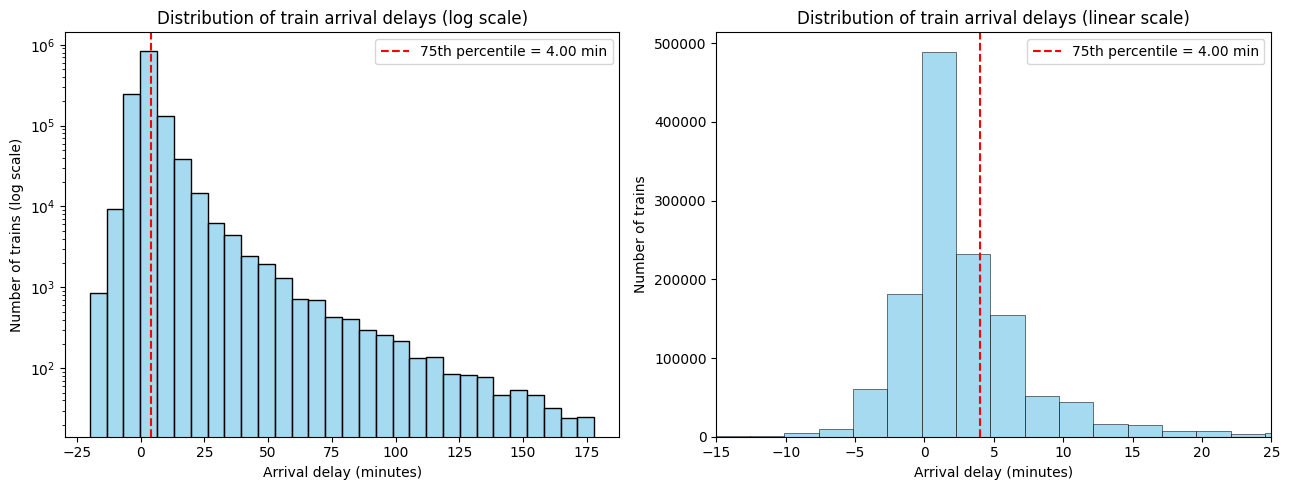

In [ ]:
# Plotting arrival delays
q75 = filtered_trains_df_ml['arrival_delay'].quantile(0.75)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5), sharey=False)

# Total delays with log scale
sns.histplot(filtered_trains_df_ml['arrival_delay'].dropna(),
             bins=30,
             color='skyblue',
             edgecolor='black',
             ax=ax1)

ax1.set_yscale('log')
ax1.set_xlabel("Arrival delay (minutes)")
ax1.set_ylabel("Number of trains (log scale)")
ax1.set_title("Distribution of train arrival delays (log scale)")
ax1.axvline(q75, color='red', linestyle='--', label=f'75th percentile = {q75:.2f} min')
ax1.legend()

# Limited delays with linear scale
sns.histplot(filtered_trains_df_ml['arrival_delay'].dropna(),
             bins=80,
             color='skyblue',
             edgecolor='black',
             ax=ax2)

ax2.set_xlim(-15, 25)
ax2.set_xlabel("Arrival delay (minutes)")
ax2.set_ylabel("Number of trains")
ax2.set_title("Distribution of train arrival delays (linear scale)")
ax2.axvline(q75, color='red', linestyle='--', label=f'75th percentile = {q75:.2f} min')
ax2.legend()

plt.tight_layout()
plt.show()

* * *

Ahora realizaré un par de verificaciones para asegurarme de que mi conjunto de datos esté completamente listo para la fase de división.

**Verificación de valores NaN restantes:**

In [ ]:
# Checking for NaN values in all columns
nan_summary = filtered_trains_df_ml.isna().sum()
total_rows = len(filtered_trains_df_ml)

nan_df = pd.DataFrame({
    "Column": nan_summary.index,
    "NaN_Count": nan_summary.values,
    "NaN_Percent": (nan_summary.values / total_rows * 100).round(2)
})

nan_df

,Column,NaN_Count,NaN_Percent
0,day,0,0.0
1,train_number,0,0.0
2,category,0,0.0
3,origin,0,0.0
4,destination,0,0.0
5,station,0,0.0
6,arrival_delay,0,0.0
7,province,0,0.0
8,scheduled_arrival_hour,0,0.0
9,scheduled_arrival_minute,0,0.0


**Verificación de que cada viaje sea único dentro de un día:**

In [ ]:
df = filtered_trains_df_ml.copy()

# Creating an indicator for a new trip compared to the previous row: a new trip occurs if the train_number or the day changes
df['new_trip'] = (df['train_number'] != df['train_number'].shift()) | (df['day'] != df['day'].shift())

# Assigning a cumulative ID to contiguous blocks of train_number/day
df['trip_block'] = df['new_trip'].cumsum()

# Counting how many separate blocks each train_number has within the same day
trip_counts = df.groupby(['day', 'train_number'], observed=True)['trip_block'].nunique()

# Identifying any train that appears in multiple separate blocks on the same day
duplicates = trip_counts[trip_counts > 1]

if duplicates.empty:
    print("No train appears in multiple separate blocks on the same day.")
else:
    print("Some trains appear in multiple separate blocks on the same day:")
    duplicates

No train appears in multiple separate blocks on the same day.


## **2. Entrenamiento del modelo: Una visión general**

### División del dataset

Antes de realizar el entrenamiento base, crearé la variable objetivo y dividiré el dataset en dos partes principales: el conjunto **trainval** (train/validation) y el conjunto **test**. Dado que el dataset abarca todos los trayectos de tren del 1 de enero al 31 de mayo, la división seguirá la progresión temporal de los datos para asegurar que el modelo se entrene de manera realista y coherente temporalmente:

- **trainval**: enero-abril (inclusive)  
- **test**: mayo  

Cada fila del dataset representa una parada de un trayecto de tren. La columna `train_id` asigna un identificador único a cada trayecto específico, el mismo para todas las paradas de ese trayecto. Usaré esa columna para asegurarme de que cualquier trayecto que cruce la división sea asignado completamente a la porción anterior. De este modo, la división en conjuntos trainval y test respetará trayectos completos. La columna `train_id` se eliminará durante el entrenamiento.

El conjunto **test** permanecerá completamente separado hasta el entrenamiento final del modelo. El conjunto **trainval** se usará tanto para el entrenamiento base como, dividido en *folds*, para el ajuste de hiperparámetros.

---

### Ingeniería de características

El modelo nunca verá directamente la columna `arrival_delay`, ya que esto generaría fuga de información directa respecto a la clasificación objetivo (retrasado si delay ≥ 4 minutos).

Sin embargo, se crearán las siguientes características históricas basadas en `arrival_delay`:

- `mean_delay_station_train`: el retraso promedio de llegada para número de tren en cada estación.  
- `mean_delay_station_train_day`: el retraso promedio de llegada para número de tren en cada estación, para cada día de la semana, capturando patrones específicos de cada día laboral.  
- `mean_delay_station_cat_day`: el retraso promedio para trenes de la misma categoría en cada estación y día de la semana, capturando comportamientos sistemáticos a nivel de categoría.  
- `mean_delay_station_day_hour_half`: el retraso promedio para cada estación en cada intervalo de media hora, diferenciado por día de la semana. Se crea una columna `hour_half`, que asigna cada hora de llegada programada a un intervalo de 30 minutos desde medianoche. Se calcula el retraso promedio de todos los trenes que llegan a esa estación dentro de ese bloque de tiempo y día de la semana. Para bloques con pocos trenes, el promedio se combina con la media general de retrasos de toda la estación. Esto suaviza el resultado y reduce el ruido en períodos con pocos datos.

Estas características contienen información histórica sobre los retrasos y serán los principales predictores para entrenar el modelo.

Al calcular las características históricas trataré temporalmente los días festivos que caen en medio de la semana laboral como si fueran sábados (`day_of_week` = 5), dado que el número de trenes en operación se asemeja más al de un sábado típico que al de un día laborable normal. Restauraré el día correcto de la semana en la columna `day_of_week`. antes de entrenar los modelos. La columna `is_holiday` seguirá presente para señalar la diferencia entre estos días laborables festivos y los días laborables normales.

---

### Entrenamiento base

Para el entrenamiento base, el conjunto **trainval** se dividirá nuevamente en un conjunto de entrenamiento y un conjunto de validación, respetando nuevamente el orden temporal:

- **Entrenamiento**: enero-marzo  
- **Validación**: abril  

Para evitar fuga de datos, las características históricas se calcularán únicamente sobre el conjunto de entrenamiento y luego esos valores se copiarán al conjunto de validación.

---

### Optimización del modelo

Para el ajuste de hiperparámetros, el conjunto **trainval** (enero-abril) se dividirá en tres folds acumulativos. Cada fold respetará tanto el orden temporal como la agrupación por `train_id`, para evitar dividir trayectos. Crearé los siguientes folds, adoptando un método de *expanding window*:

| Fold | Entrenamiento | Validación |
|------|---------------|------------|
| 1    | Enero         | Febrero    |
| 2    | Enero-Febrero | Marzo      |
| 3    | Enero-Marzo   | Abril      |

Para cada fold:

1. Las características históricas se calcularán solo sobre la porción de entrenamiento del fold.  
2. Los valores resultantes se asignarán a la porción de validación del fold.  
3. Las métricas de rendimiento recopiladas durante el ajuste de hiperparámetros se promediarán entre los folds para seleccionar los mejores hiperparámetros.

> Nota: Crearé los folds manualmente, ya que `GroupKFold` por sí solo no permite respetar el orden temporal y `TimeSeriesSplit` no permite agrupar.

---

### Evaluación del modelo

El modelo final se entrenará sobre todo el conjunto **trainval** (enero-abril) usando los mejores hiperparámetros seleccionados durante la validación cruzada.

- Las características históricas se calcularán sobre todo el conjunto **trainval**.  
- Finalmente, el modelo se evaluará sobre el conjunto  **test** (mayo), que permanece completamente aislado, para estimar el rendimiento en condiciones reales.

## **3. División del conjunto de datos y preparación para la ingeniería de características**

### **3.1 Establecimiento del umbral de retraso y definición de la variable objetivo**

In [ ]:
THRESHOLD_MIN = 4

# Creating the binary target feature (delay >= threshold) on the whole dataset
filtered_trains_df_ml["target_delay_threshold"] = (
    filtered_trains_df_ml["arrival_delay"] >= THRESHOLD_MIN
).astype(int)

display(filtered_trains_df_ml.head(2))

,day,train_number,category,origin,destination,station,arrival_delay,province,scheduled_arrival_hour,scheduled_arrival_minute,day_of_week,previous_station,train_id,stop_index,n_stops_total,is_holiday,target_delay_threshold
0,2025-01-01,32,EC,VENEZIA_SANTA_LUCIA,CHIASSO,VENEZIA_MESTRE,3,VE,15,28,2,VENEZIA_SANTA_LUCIA,1,0,9,1,0
1,2025-01-01,32,EC,VENEZIA_SANTA_LUCIA,CHIASSO,PADOVA,3,PD,15,44,2,VENEZIA_MESTRE,1,1,9,1,0


In [ ]:
filtered_trains_df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302999 entries, 0 to 1302998
Data columns (total 17 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   day                       1302999 non-null  datetime64[ns]
 1   train_number              1302999 non-null  category      
 2   category                  1302999 non-null  category      
 3   origin                    1302999 non-null  category      
 4   destination               1302999 non-null  category      
 5   station                   1302999 non-null  category      
 6   arrival_delay             1302999 non-null  int64         
 7   province                  1302999 non-null  category      
 8   scheduled_arrival_hour    1302999 non-null  int64         
 9   scheduled_arrival_minute  1302999 non-null  int64         
 10  day_of_week               1302999 non-null  category      
 11  previous_station          1302999 non-null  catego

### **3.2 División del conjunto de datos en trainval y test**

In [ ]:
# Setting date boundary for trainval/test split
trainval_end = '2025-04-30'

# Identifying train_ids in trainval and test ranges
trainval_cutoff_ids = filtered_trains_df_ml[filtered_trains_df_ml['day'] <= trainval_end]['train_id'].unique()
test_cutoff_ids = filtered_trains_df_ml[filtered_trains_df_ml['day'] > trainval_end]['train_id'].unique()

# Finding train_ids that appear in both portions
overlap_ids = set(trainval_cutoff_ids) & set(test_cutoff_ids)

# Assigning all overlapping train_ids entirely to trainval
trainval_df = filtered_trains_df_ml[
    (filtered_trains_df_ml['day'] <= trainval_end) |
    (filtered_trains_df_ml['train_id'].isin(overlap_ids))
].copy()

# Assigning remaining rows to test set
test_df = filtered_trains_df_ml[
    (filtered_trains_df_ml['day'] > trainval_end) &
    (~filtered_trains_df_ml['train_id'].isin(overlap_ids))
].copy()

# Sanity check
print(f"Trainval rows: {len(trainval_df)}")
print(f"Test rows: {len(test_df)}")
print(f"Number of train_ids fully assigned to trainval due to overlap: {len(overlap_ids)}")

Trainval rows: 1040615
Test rows: 262384
Number of train_ids fully assigned to trainval due to overlap: 0


### **3.3 Funciones para la ingeniería de características**

**Función que calcula y añade características históricas al conjunto de datos de entrenamiento:**

In [ ]:
def add_hist_features(df):
    df = df.copy()

    # temporarily assigning day_of_week = 5 for weekday holidays
    df["_original_day_of_week"] = df["day_of_week"]
    df.loc[df["is_holiday"] == 1, "day_of_week"] = 5

    # mean_delay_station_train_day (with hierarchical fallbacks)
    exact_train_day = (
        df.groupby(["train_number", "station", "day_of_week"], observed=False)["arrival_delay"]
        .mean()
        .reset_index()
        .rename(columns={"arrival_delay": "mean_delay_station_train_day"})
    )
    df = df.merge(exact_train_day, on=["train_number", "station", "day_of_week"], how="left")

    fallback_train_station = (
        exact_train_day.groupby(["train_number", "station"], observed=False)["mean_delay_station_train_day"]
        .mean()
        .reset_index()
    )
    fallback_train_station.rename(columns={"mean_delay_station_train_day": "mean_delay_station_train_day_fb1"}, inplace=True)
    df = df.merge(fallback_train_station, on=["train_number", "station"], how="left")
    df["mean_delay_station_train_day"] = df["mean_delay_station_train_day"].fillna(df["mean_delay_station_train_day_fb1"])
    df.drop(columns=["mean_delay_station_train_day_fb1"], inplace=True)

    fallback_station = (
        df.groupby("station", observed=False)["mean_delay_station_train_day"]
        .mean()
        .reset_index()
        .rename(columns={"mean_delay_station_train_day": "mean_delay_station_train_day_fb2"})
    )
    df = df.merge(fallback_station, on="station", how="left")
    df["mean_delay_station_train_day"] = df["mean_delay_station_train_day"].fillna(df["mean_delay_station_train_day_fb2"])
    df.drop(columns=["mean_delay_station_train_day_fb2"], inplace=True)

    # mean_delay_station_train (with fallback)
    exact_train_station = (
        df.groupby(["train_number", "station"], observed=False)["arrival_delay"]
        .mean()
        .reset_index()
        .rename(columns={"arrival_delay": "mean_delay_station_train"})
    )
    df = df.merge(exact_train_station, on=["train_number", "station"], how="left")

    fallback_station_mean = (
        exact_train_station.groupby("station", observed=False)["mean_delay_station_train"]
        .mean()
        .reset_index()
        .rename(columns={"mean_delay_station_train": "mean_delay_station_train_fb"})
    )
    df = df.merge(fallback_station_mean, on="station", how="left")
    df["mean_delay_station_train"] = df["mean_delay_station_train"].fillna(df["mean_delay_station_train_fb"])
    df.drop(columns=["mean_delay_station_train_fb"], inplace=True)

    # mean_delay_station_cat_day (with fallback)
    exact_cat = (
        df.groupby(["category", "station", "day_of_week"], observed=False)["arrival_delay"]
        .mean()
        .reset_index()
        .rename(columns={"arrival_delay": "mean_delay_station_cat_day"})
    )
    df = df.merge(exact_cat, on=["category", "station", "day_of_week"], how="left")

    fallback_cat_station = (
        exact_cat.groupby(["category", "station"], observed=False)["mean_delay_station_cat_day"]
        .mean()
        .reset_index()
        .rename(columns={"mean_delay_station_cat_day": "mean_delay_station_cat_day_fb"})
    )
    df = df.merge(fallback_cat_station, on=["category", "station"], how="left")
    df["mean_delay_station_cat_day"] = df["mean_delay_station_cat_day"].fillna(df["mean_delay_station_cat_day_fb"])
    df.drop(columns=["mean_delay_station_cat_day_fb"], inplace=True)

    # hour_half
    df["hour_half"] = (df["scheduled_arrival_hour"] * 60 + df["scheduled_arrival_minute"]) // 30

    # mean_delay_station_day_hour_half (with smoothing and fallback)
    counts = df.groupby(["station", "day_of_week", "hour_half"], observed=False)["arrival_delay"] \
               .count().reset_index().rename(columns={"arrival_delay": "counts"})
    means_half = df.groupby(["station", "day_of_week", "hour_half"], observed=False)["arrival_delay"] \
                   .mean().reset_index().rename(columns={"arrival_delay": "mean_half"})
    means_station_day = df.groupby(["station", "day_of_week"], observed=False)["arrival_delay"] \
                          .mean().reset_index().rename(columns={"arrival_delay": "mean_station_day"})

    df = df.merge(counts, on=["station", "day_of_week", "hour_half"], how="left")
    df = df.merge(means_half, on=["station", "day_of_week", "hour_half"], how="left")
    df = df.merge(means_station_day, on=["station", "day_of_week"], how="left")

    k = 5
    df["mean_delay_station_day_hour_half"] = (df["counts"] * df["mean_half"] + k * df["mean_station_day"]) / (df["counts"] + k)

    df.drop(columns=["counts", "mean_half", "mean_station_day"], inplace=True)

    # restoring original day_of_week
    df["day_of_week"] = df["_original_day_of_week"]
    df.drop(columns=["_original_day_of_week"], inplace=True)

    return df

**Función que copia las características históricas del conjunto de datos de entrenamiento a un segundo conjunto de datos para usarlo como validación:**

In [ ]:
def copy_hist_features(source_df, target_df):
    df = target_df.copy()

    # temporarily assigning day_of_week = 5 for weekday holidays
    df["_original_day_of_week"] = df["day_of_week"]
    df.loc[df["is_holiday"] == 1, "day_of_week"] = 5

    # mean_delay_station_train_day (with hierarchical fallbacks)
    exact = (
        source_df.groupby(["train_number", "station", "day_of_week"], observed=False)["mean_delay_station_train_day"]
        .mean()
        .reset_index()
    )
    df = df.merge(exact, on=["train_number", "station", "day_of_week"], how="left")

    fallback_train_station = (
        source_df.groupby(["train_number", "station"], observed=False)["mean_delay_station_train_day"]
        .mean()
        .reset_index()
        .rename(columns={"mean_delay_station_train_day": "mean_delay_station_train_day_fb1"})
    )
    df = df.merge(fallback_train_station, on=["train_number", "station"], how="left")
    df["mean_delay_station_train_day"] = df["mean_delay_station_train_day"].fillna(df["mean_delay_station_train_day_fb1"])
    df.drop(columns=["mean_delay_station_train_day_fb1"], inplace=True)

    fallback_station = (
        source_df.groupby("station", observed=False)["mean_delay_station_train_day"]
        .mean()
        .reset_index()
        .rename(columns={"mean_delay_station_train_day": "mean_delay_station_train_day_fb2"})
    )
    df = df.merge(fallback_station, on="station", how="left")
    df["mean_delay_station_train_day"] = df["mean_delay_station_train_day"].fillna(df["mean_delay_station_train_day_fb2"])
    df.drop(columns=["mean_delay_station_train_day_fb2"], inplace=True)

    # mean_delay_station_train (with fallback)
    exact_train_station = (
        source_df.groupby(["train_number", "station"], observed=False)["mean_delay_station_train"]
        .mean()
        .reset_index()
    )
    df = df.merge(exact_train_station, on=["train_number", "station"], how="left")

    fallback_station_mean = (
        source_df.groupby("station", observed=False)["mean_delay_station_train"]
        .mean()
        .reset_index()
        .rename(columns={"mean_delay_station_train": "mean_delay_station_train_fb"})
    )
    df = df.merge(fallback_station_mean, on="station", how="left")
    df["mean_delay_station_train"] = df["mean_delay_station_train"].fillna(df["mean_delay_station_train_fb"])
    df.drop(columns=["mean_delay_station_train_fb"], inplace=True)

    # mean_delay_station_cat_day (with fallback)
    exact_cat = (
        source_df.groupby(["category", "station", "day_of_week"], observed=False)["mean_delay_station_cat_day"]
        .mean()
        .reset_index()
    )
    df = df.merge(exact_cat, on=["category", "station", "day_of_week"], how="left")

    fallback_cat_station = (
        source_df.groupby(["category", "station"], observed=False)["mean_delay_station_cat_day"]
        .mean()
        .reset_index()
        .rename(columns={"mean_delay_station_cat_day": "mean_delay_station_cat_day_fb"})
    )
    df = df.merge(fallback_cat_station, on=["category", "station"], how="left")
    df["mean_delay_station_cat_day"] = df["mean_delay_station_cat_day"].fillna(df["mean_delay_station_cat_day_fb"])
    df.drop(columns=["mean_delay_station_cat_day_fb"], inplace=True)

    # hour_half
    df["hour_half"] = (df["scheduled_arrival_hour"] * 60 + df["scheduled_arrival_minute"]) // 30

    # mean_delay_station_day_hour_half (with fallback)
    exact_half = (
        source_df.groupby(["station", "day_of_week", "hour_half"], observed=False)["mean_delay_station_day_hour_half"]
        .mean()
        .reset_index()
    )
    df = df.merge(exact_half, on=["station", "day_of_week", "hour_half"], how="left")

    fallback_station_day = (
        source_df.groupby(["station", "day_of_week"], observed=False)["mean_delay_station_day_hour_half"]
        .mean()
        .reset_index()
        .rename(columns={"mean_delay_station_day_hour_half": "mean_delay_station_day_hour_half_fb"})
    )
    df = df.merge(fallback_station_day, on=["station", "day_of_week"], how="left")
    df["mean_delay_station_day_hour_half"] = df["mean_delay_station_day_hour_half"].fillna(
        df["mean_delay_station_day_hour_half_fb"]
    )
    df.drop(columns=["mean_delay_station_day_hour_half_fb"], inplace=True)

    # restoring original day_of_week
    df["day_of_week"] = df["_original_day_of_week"]
    df.drop(columns=["_original_day_of_week"], inplace=True)

    return df

## **4. Entrenamiento base**

Ahora procederé con el entrenamiento base de dos modelos, LightGBM y CatBoost, y compararé sus métricas.

Dividiré el conjunto **trainval** en dos subconjuntos: el conjunto de entrenamiento, que consta de los meses de enero a marzo, y el conjunto de validación, que consta de abril.

Las características históricas se calcularán en el conjunto de entrenamiento y sus valores se copiarán en el conjunto de validación.

### **4.1 División del conjunto trainval en train y val**

In [ ]:
# Defining the train/validation cutoff
train_end_date = '2025-03-31'
val_start_date = '2025-04-01'

# Preventing separation of entries belonging to the same trip (based on train_id)
train_cutoff_ids = trainval_df[trainval_df['day'] <= train_end_date]['train_id'].unique()
val_cutoff_ids   = trainval_df[trainval_df['day'] >= val_start_date]['train_id'].unique()

# Identify overlapping train_ids (trips that span the boundary)
overlap_ids = set(train_cutoff_ids) & set(val_cutoff_ids)

# Creating train and validation sets
train_df = trainval_df[
    (trainval_df['day'] <= train_end_date) |
    (trainval_df['train_id'].isin(overlap_ids))
].copy()

val_df = trainval_df[
    (trainval_df['day'] >= val_start_date) &
    (~trainval_df['train_id'].isin(overlap_ids))
].copy()

# Computing historical features on train
train_df = add_hist_features(train_df)

# Copying historical features to validation
val_df = copy_hist_features(train_df, val_df)

### **4.2 Entrenamiento de los modelos base**

In [ ]:
# Defining features & target (excluding day, arrival_delay, train_id, hour_half from train)
features = [
    "stop_index",
    "n_stops_total",
    "scheduled_arrival_hour",
    "scheduled_arrival_minute",
    "mean_delay_station_train_day",
    "mean_delay_station_train",
    "mean_delay_station_cat_day",
    "mean_delay_station_day_hour_half",
    "is_holiday"
]

categorical_features = [
    "category",
    "origin",
    "destination",
    "station",
    "previous_station",
    "province",
    "day_of_week",
    "train_number"
]

target = "target_delay_threshold"

X_train = train_df[features + categorical_features]
y_train = train_df[target]

X_val = val_df[features + categorical_features]
y_val = val_df[target]


# LightGBM baseline
lgb_model = lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)

start_time = time()
lgb_model.fit(X_train, y_train, categorical_feature=categorical_features)
lgb_train_time = time() - start_time


# CatBoost baseline
cat_model = CatBoostClassifier(
    iterations=100,
    random_seed=42,
    verbose=False
)

start_time = time()
cat_model.fit(X_train, y_train, cat_features=categorical_features)
cat_train_time = time() - start_time

### **4.3 Resultados**

,Model,Threshold,Precision,Recall,F1,ROC_AUC,PR_AUC,Train_Time
0,LightGBM,0.323232,0.559325,0.705684,0.624038,0.793887,0.682143,12.65
1,CatBoost,0.333333,0.560315,0.695706,0.620714,0.790066,0.676646,48.71


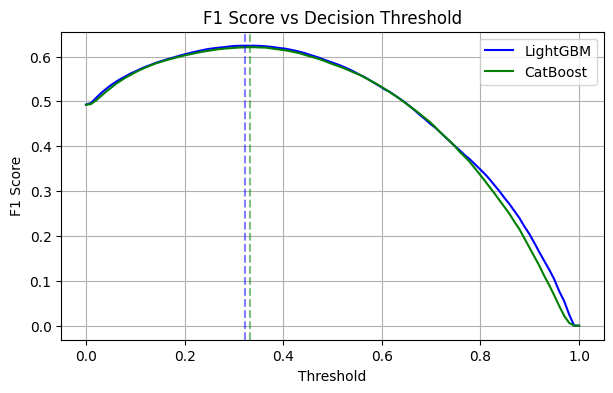

In [ ]:
# Collecting probabilities predicted from the baseline models
lgb_proba = lgb_model.predict_proba(X_val)[:, 1]
cat_proba = cat_model.predict_proba(X_val)[:, 1]

# Calculating the probability threshold that maximizes F1 score
def best_f1_threshold(y_true, y_prob, steps=100):
    thresholds = np.linspace(0, 1, steps)
    f1_scores = [f1_score(y_true, (y_prob >= t).astype(int)) for t in thresholds]
    best_idx = np.argmax(f1_scores)
    return thresholds[best_idx], f1_scores[best_idx]

best_f1_threshold_lgb, best_f1_lgb = best_f1_threshold(y_val, lgb_proba)
best_f1_threshold_cat, best_f1_cat = best_f1_threshold(y_val, cat_proba)

# Calculating binary predictions based on the best probability threshold
lgb_preds_best = (lgb_proba >= best_f1_threshold_lgb).astype(int)
cat_preds_best = (cat_proba >= best_f1_threshold_cat).astype(int)

# Calculating metrics based on the binary predictions based on the probability threshold that maximizes F1 score
metrics = []

# LightGBM
metrics.append({
    "Model": "LightGBM",
    "Threshold": best_f1_threshold_lgb,
    "Precision": precision_score(y_val, lgb_preds_best),
    "Recall": recall_score(y_val, lgb_preds_best),
    "F1": f1_score(y_val, lgb_preds_best),
    "ROC_AUC": roc_auc_score(y_val, lgb_proba),
    "PR_AUC" : average_precision_score(y_val, lgb_proba),
    "Train_Time": lgb_train_time
})

# CatBoost
metrics.append({
    "Model": "CatBoost",
    "Threshold": best_f1_threshold_cat,
    "Precision": precision_score(y_val, cat_preds_best),
    "Recall": recall_score(y_val, cat_preds_best),
    "F1": f1_score(y_val, cat_preds_best),
    "ROC_AUC": roc_auc_score(y_val, cat_proba),
    "PR_AUC" : average_precision_score(y_val, cat_proba),
    "Train_Time": cat_train_time
})

# Showing metrics in a dataframe
metrics_df = pd.DataFrame(metrics)
metrics_df = metrics_df[["Model", "Threshold", "Precision", "Recall", "F1", "ROC_AUC", "PR_AUC", "Train_Time"]]
metrics_df['Train_Time'] = metrics_df['Train_Time'].round(2)

display(metrics_df)


# Function to calculate F1 score for all probability thresholds
def f1_curve(y_true, y_prob, steps=100):
    thresholds = np.linspace(0, 1, steps)
    f1_scores = [f1_score(y_true, (y_prob >= t).astype(int)) for t in thresholds]
    return thresholds, f1_scores

# Calculating F1 score curve
thresholds_lgb, f1_scores_lgb = f1_curve(y_val, lgb_proba)
thresholds_cat, f1_scores_cat = f1_curve(y_val, cat_proba)

# Plotting curve
plt.figure(figsize=(7,4))
plt.plot(thresholds_lgb, f1_scores_lgb, label='LightGBM', color='blue')
plt.plot(thresholds_cat, f1_scores_cat, label='CatBoost', color='green')
plt.axvline(x=best_f1_threshold_lgb, color='blue', linestyle='--', alpha=0.5)
plt.axvline(x=best_f1_threshold_cat, color='green', linestyle='--', alpha=0.5)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Decision Threshold')
plt.legend()
plt.grid(True)
plt.show()

He recopilado métricas de rendimiento optimizadas para el mejor F1 score. En un problema de predicción de retrasos de trenes, el objetivo suele ser identificar la mayor cantidad posible de retrasos reales (alta recall) sin saturar al usuario con falsas alarmas (precisión demasiado baja). Por lo tanto, prefiero lograr el mejor equilibrio entre ambas métricas.

Los dos modelos obtuvieron un rendimiento muy similar, con un balance comparable entre precisión y recall. La principal diferencia radica en el tiempo de entrenamiento: LightGBM se entrenó mucho más rápido que CatBoost, mientras que entregó resultados esencialmente equivalentes en términos de calidad de predicción.

También experimenté con estrategias de entrenamiento que compensan el desequilibrio de clases, usando `class_weight='balanced'` en LightGBM (que ajusta automáticamente el peso de cada clase inversamente proporcional a su frecuencia) y `class_weights=[1, (len(y_train)-sum(y_train))/sum(y_train)]` en CatBoost (estableciendo manualmente un peso mayor para la clase minoritaria). Sin embargo, las métricas resultantes fueron bastante similares al entrenamiento estándar, lo que indica que los modelos ya estaban manejando razonablemente bien el desequilibrio.

En la siguiente etapa de ajuste de hiperparámetros, me centraré exclusivamente en LightGBM. Su tiempo de entrenamiento muy corto me permitirá explorar un mayor número de combinaciones de hiperparámetros de manera más eficiente, sin sacrificar el rendimiento predictivo.

## **5. Optimización del modelo**

Ahora realizaré el ajuste de hiperparámetros del modelo LightGBM. Para ello, prepararé 3 folds para la validación cruzada, basados en el conjunto **trainval** (que incluye los trayectos del 1 de enero al 30 de abril).

Adopto un enfoque de validación cruzada progresiva: cada fold utiliza un conjunto de entrenamiento creciente, en lugar de subconjuntos completamente diferentes. Los folds se definen de la siguiente manera:

| Fold | Entrenamiento | Validación |
|------|---------------|------------|
| 1    | Enero         | Febrero    |
| 2    | Enero-Febrero | Marzo      |
| 3    | Enero-Marzo   | Abril      |

Para cada fold, calcularé las características históricas sobre la porción de entrenamiento y las copiaré en el conjunto de validación correspondiente.

Dado que quiero preservar tanto los subgrupos existentes (evitando dividir trayectos a lo largo de los folds) como el orden temporal (entrenando con trayectos más antiguos y validando con los más recientes), no puedo usar directamente `GroupKFold` ni `TimeSeriesSplit`. Por ello, construiré los folds manualmente. Al igual que en la división trainval/test realizada antes del entrenamiento base, crearé los tres folds y los conjuntos de entrenamiento/validación correspondientes dentro de cada fold cuidando de no separar entre distintos folds filas contiguas que pertenezcan al mismo trayecto.

En general, este enfoque asegura que:

1. Cada fold respete el orden temporal del dataset.  
2. Las características históricas siempre se calculen únicamente sobre la porción de entrenamiento del fold, evitando fuga de datos.  
3. El modelo aprenda a manejar cantidades progresivamente mayores de datos históricos, lo que es realista y debería ayudarle a generalizar mejor.

Para el ajuste de hiperparámetros, habría utilizado `RandomizedSearchCV`, ya que permite explorar el espacio de hiperparámetros de manera eficiente en términos de tiempo y recursos computacionales. Sin embargo, este enfoque no garantiza que se respeten los folds de validación cruzada definidos manualmente. Por ello, también implementaré la búsqueda de hiperparámetros de forma manual. Cada ciclo de entrenamiento se evaluará utilizando el umbral de probabilidad que maximice el F1.

### **5.1 Configuración de los folds**

In [ ]:
folds = []

# Fold 1: train Jan, val Feb
train_ids_1 = trainval_df[trainval_df['day'] < '2025-02-01']['train_id'].unique()
val_ids_1   = trainval_df[(trainval_df['day'] >= '2025-02-01') & (trainval_df['day'] < '2025-03-01')]['train_id'].unique()
overlap_1   = set(train_ids_1) & set(val_ids_1)

train_fold_1 = trainval_df[(trainval_df['train_id'].isin(train_ids_1)) | (trainval_df['train_id'].isin(overlap_1))].copy()
val_fold_1   = trainval_df[(trainval_df['train_id'].isin(val_ids_1)) & (~trainval_df['train_id'].isin(overlap_1))].copy()

train_fold_1 = add_hist_features(train_fold_1)
val_fold_1 = copy_hist_features(train_fold_1, val_fold_1)

folds.append({'train': train_fold_1, 'val': val_fold_1})


# Fold 2: train Jan-Feb, val Mar
train_ids_2 = trainval_df[trainval_df['day'] < '2025-03-01']['train_id'].unique()
val_ids_2   = trainval_df[(trainval_df['day'] >= '2025-03-01') & (trainval_df['day'] < '2025-04-01')]['train_id'].unique()
overlap_2   = set(train_ids_2) & set(val_ids_2)

train_fold_2 = trainval_df[(trainval_df['train_id'].isin(train_ids_2)) | (trainval_df['train_id'].isin(overlap_2))].copy()
val_fold_2   = trainval_df[(trainval_df['train_id'].isin(val_ids_2)) & (~trainval_df['train_id'].isin(overlap_2))].copy()

train_fold_2 = add_hist_features(train_fold_2)
val_fold_2 = copy_hist_features(train_fold_2, val_fold_2)

folds.append({'train': train_fold_2, 'val': val_fold_2})


# Fold 3: train Jan-Mar, val Apr
train_ids_3 = trainval_df[trainval_df['day'] < '2025-04-01']['train_id'].unique()
val_ids_3   = trainval_df[trainval_df['day'] >= '2025-04-01']['train_id'].unique()
overlap_3   = set(train_ids_3) & set(val_ids_3)

train_fold_3 = trainval_df[(trainval_df['train_id'].isin(train_ids_3)) | (trainval_df['train_id'].isin(overlap_3))].copy()
val_fold_3   = trainval_df[(trainval_df['train_id'].isin(val_ids_3)) & (~trainval_df['train_id'].isin(overlap_3))].copy()

train_fold_3 = add_hist_features(train_fold_3)
val_fold_3 = copy_hist_features(train_fold_3, val_fold_3)

folds.append({'train': train_fold_3, 'val': val_fold_3})


# Checking fold sizes
for i, fold in enumerate(folds, 1):
    print(f"Fold {i}: Train rows = {len(fold['train'])}, Validation rows = {len(fold['val'])}")

Fold 1: Train rows = 264184, Validation rows = 248890
Fold 2: Train rows = 513074, Validation rows = 267743
Fold 3: Train rows = 780817, Validation rows = 259798


### **5.2 Ajuste de hiperparámetros**

Realizaré el ajuste de hiperparámetros muestreando 200 combinaciones de una cuadrícula predefinida de parámetros clave. Establezco 2000 iteraciones de *boosting*, confiando en el *early stopping* con 50 rondas para detener automáticamente el entrenamiento cuando el rendimiento en validación se estabilice.

El ajuste se realiza sobre los tres *folds* acumulativos, respetando el orden temporal y manteniendo los trayectos juntos. Para cada combinación, evalúo las métricas por *fold* y selecciono los hiperparámetros que maximizan el F1 promedio a través de los *folds*.

In [ ]:
random.seed(42)
np.random.seed(42)

# Defining features & target (excluding day, arrival_delay, train_id, hour_half from train)
features = [
    "stop_index",
    "n_stops_total",
    "scheduled_arrival_hour",
    "scheduled_arrival_minute",
    "mean_delay_station_train_day",
    "mean_delay_station_train",
    "mean_delay_station_cat_day",
    "mean_delay_station_day_hour_half",
    "is_holiday"
]

categorical_features = [
    "category",
    "origin",
    "destination",
    "station",
    "previous_station",
    "province",
    "day_of_week",
    "train_number"
]

target = "target_delay_threshold"


# Transforming each fold into matrices for LightGBM
for fold in folds:
    X_train_fold = fold['train'][features + categorical_features]
    y_train_fold = fold['train'][target]

    X_val_fold = fold['val'][features + categorical_features]
    y_val_fold = fold['val'][target]

    fold.update({
        "X_train": X_train_fold,
        "y_train": y_train_fold,
        "X_val": X_val_fold,
        "y_val": y_val_fold,
        "categorical_features": categorical_features
    })


# Hyperparameter grid
param_grid = {
    'num_leaves': [31, 63, 127, 150, 180],
    'max_depth': [-1, 10, 15, 20, 25],
    'min_data_in_leaf': [15, 20, 30, 50, 100],
    'learning_rate': [0.01, 0.05],
    'feature_fraction': [0.7, 0.85, 1.0],
    'bagging_fraction': [0.7, 0.85, 1.0],
    'reg_alpha': [0, 0.05, 0.1, 0.2, 1],
    'reg_lambda': [0, 0.05, 0.1, 0.2, 1]
}


# Random sampling
all_combinations = list(product(*param_grid.values()))
random.shuffle(all_combinations)
n_trials = 200
param_combinations = all_combinations[:n_trials]


start_time = time()
best_f1 = 0
best_params = None
best_fold_metrics = []

for trial_idx, params_tuple in enumerate(param_combinations, 1):
    params = dict(zip(param_grid.keys(), params_tuple))
    params.update({'objective': 'binary', 'metric': 'binary_logloss', 'seed': 42, 'n_jobs': -1, 'verbose': -1})

    temp_fold_metrics = []

    for fold_idx, fold in enumerate(folds, 1):
        X_tr, y_tr = fold["X_train"], fold["y_train"]
        X_val, y_val = fold["X_val"], fold["y_val"]

        lgb_train = lgb.Dataset(X_tr, label=y_tr, categorical_feature=categorical_features)
        lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

        model = lgb.train(
            params=params,
            train_set=lgb_train,
            valid_sets=[lgb_val],
            num_boost_round=2000,
            callbacks=[lgb.early_stopping(stopping_rounds=50)]
        )

        # Predicting probabilities and finding best threshold for F1
        y_prob = model.predict(X_val)
        best_thresh, fold_best_f1 = best_f1_threshold(y_val, y_prob)

        temp_fold_metrics.append({
            "Fold": fold_idx,
            "Threshold": best_thresh,
            "Precision": precision_score(y_val, (y_prob >= best_thresh).astype(int)),
            "Recall": recall_score(y_val, (y_prob >= best_thresh).astype(int)),
            "F1": fold_best_f1,
            "ROC_AUC": roc_auc_score(y_val, y_prob),
            "PR_AUC": average_precision_score(y_val, y_prob)
        })

        print(f"Trial {trial_idx}/{n_trials}, Fold {fold_idx}/{len(folds)} finished.")

    avg_f1 = np.mean([m['F1'] for m in temp_fold_metrics])
    if avg_f1 > best_f1:
        best_f1 = avg_f1
        best_params = params
        best_fold_metrics = temp_fold_metrics  # keeping metrics for best hyperparameters

hyperparameter_tuning_train_time = time() - start_time


# Creating a dataframe for the best hyperparameters combination
display_params = {k: v for k, v in best_params.items() if k not in ['objective', 'metric', 'seed', 'n_jobs', 'verbose']}
best_params_df = pd.DataFrame([display_params]).T
best_params_df.columns = ['Value']

# Creating a dataframe for per-fold metrics of the best hyperparameters combination
metrics_df = pd.DataFrame(best_fold_metrics)

print(f"\nHyperparameter tuning time: {hyperparameter_tuning_train_time:.2f} seconds")

print("\nBest hyperparameters:")
display(best_params_df)

print("\nPer-fold metrics for the best hyperparameter combination (highest average F1 across folds):")
display(metrics_df)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[141]	valid_0's binary_logloss: 0.518179
Trial 1/200, Fold 1/3 finished.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[199]	valid_0's binary_logloss: 0.521776
Trial 1/200, Fold 2/3 finished.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[258]	valid_0's binary_logloss: 0.499839
Trial 1/200, Fold 3/3 finished.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.516897
Trial 2/200, Fold 1/3 finished.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.522179
Trial 2/200, Fold 2/3 finished.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	valid_0's binary_logloss: 0.499835
Trial 2/200, Fold 3/3

,Value
num_leaves,150.00
max_depth,20.00
min_data_in_leaf,100.00
learning_rate,0.01
feature_fraction,0.70
bagging_fraction,0.70
reg_alpha,1.00
reg_lambda,1.00



Per-fold metrics for the best hyperparameter combination (highest average F1 across folds):


,Fold,Threshold,Precision,Recall,F1,ROC_AUC,PR_AUC
0,1,0.313131,0.533338,0.706764,0.607925,0.780878,0.674736
1,2,0.313131,0.575236,0.694033,0.629075,0.785418,0.688227
2,3,0.333333,0.567075,0.698427,0.625934,0.795243,0.684008


Los parámetros seleccionados conducen a una configuración que se comporta de manera bastante similar en las distintas divisiones del dataset.

El proceso de ajuste eligió parámetros que permiten árboles más profundos y un mayor número de hojas, combinados con una regularización relativamente fuerte. Esto significa que el modelo tiene suficiente capacidad para capturar patrones, pero también está limitado para evitar sobreajuste.

Los resultados de validación son consistentes entre los folds. Precisión y recall están equilibradas, con recall ligeramente superior, lo que indica que el modelo tiende a identificar con más frecuencia los casos positivos. Los valores de ROC-AUC y PR-AUC son estables y muestran que el modelo es capaz de separar las clases de manera confiable.

Ahora entrenaré y evaluaré el modelo final, adoptando los hiperparámetros seleccionados.

## **6. Entrenamiento y evaluación final**

### **6.1 Entrenamiento final**

Entrenaré el modelo final utilizando el conjunto **trainval** completo (viajes del 1 de enero al 30 de abril) como datos de entrenamiento. Uutilizaré el conjunto **test** (viajes de mayo) para la evaluación. Como de costumbre, las características históricas se calcularán en el conjunto de entrenamiento y se copiarán al conjunto **test** para evitar fuga de datos.

In [ ]:
# Applying historical features to the training set and copying them to the test set
train_df = add_hist_features(trainval_df)
test_df_with_hist = copy_hist_features(train_df, test_df)

# Defining features & target (excluding day, arrival_delay, train_id, hour_half from train)
features = [
    "stop_index",
    "n_stops_total",
    "scheduled_arrival_hour",
    "scheduled_arrival_minute",
    "mean_delay_station_train_day",
    "mean_delay_station_train",
    "mean_delay_station_cat_day",
    "mean_delay_station_day_hour_half",
    "is_holiday"
]

categorical_features = [
    "category",
    "origin",
    "destination",
    "station",
    "previous_station",
    "province",
    "day_of_week",
    "train_number"
]

target = "target_delay_threshold"


# Extracting X and y matrices for LightGBM
X_train = train_df[features + categorical_features]
y_train = train_df[target]

X_val = test_df_with_hist[features + categorical_features]
y_val = test_df_with_hist[target]

print("Training and validation matrices prepared:")
print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape, "y_val shape:", y_val.shape)

Training and validation matrices prepared:
X_train shape: (1040615, 17) y_train shape: (1040615,)
X_val shape: (262384, 17) y_val shape: (262384,)


In [ ]:
lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
lgb_val = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_features, reference=lgb_train)

final_params = best_params.copy()
final_params.update({
    'objective': 'binary',
    'metric': 'binary_logloss',
    'seed': 42,
    'verbose': -1
})

start_time = time()

final_model = lgb.train(
    params=final_params,
    train_set=lgb_train,
    valid_sets=[lgb_val],
    num_boost_round=2000,
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

final_train_time = time() - start_time
print(f"Final model trained in {final_train_time:.2f} seconds.")

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[248]	valid_0's binary_logloss: 0.518279
Final model trained in 94.08 seconds.


### **6.2 Evaluación**

In [ ]:
# Probabilities on final train set
lgb_proba_train = final_model.predict(X_train)
lgb_preds_train = (lgb_proba_train >= best_f1_threshold_lgb).astype(int)

# Probabilities on final test set
lgb_proba_test = final_model.predict(X_val)
lgb_preds_test = (lgb_proba_test >= best_f1_threshold_lgb).astype(int)

# Metrics
final_metrics = []

final_metrics.append({
    "Set": "Train",
    "Threshold": best_f1_threshold_lgb,
    "Precision": precision_score(y_train, lgb_preds_train),
    "Recall": recall_score(y_train, lgb_preds_train),
    "F1": f1_score(y_train, lgb_preds_train),
    "ROC_AUC": roc_auc_score(y_train, lgb_proba_train),
    "PR_AUC": average_precision_score(y_train, lgb_proba_train)
})

final_metrics.append({
    "Set": "Test",
    "Threshold": best_f1_threshold_lgb,
    "Precision": precision_score(y_val, lgb_preds_test),
    "Recall": recall_score(y_val, lgb_preds_test),
    "F1": f1_score(y_val, lgb_preds_test),
    "ROC_AUC": roc_auc_score(y_val, lgb_proba_test),
    "PR_AUC": average_precision_score(y_val, lgb_proba_test)
})

final_metrics_df = pd.DataFrame(final_metrics)
final_metrics_df = final_metrics_df[["Set", "Threshold", "Precision", "Recall", "F1", "ROC_AUC", "PR_AUC"]]
display(final_metrics_df)

,Set,Threshold,Precision,Recall,F1,ROC_AUC,PR_AUC
0,Train,0.323232,0.598536,0.757097,0.668544,0.837402,0.740003
1,Test,0.323232,0.578841,0.693808,0.631132,0.787297,0.689995


En comparación con el conjunto de entrenamiento, la precisión en el conjunto **test** disminuye ligeramente, mientras que la recall también baja pero sigue siendo superior a la precisión, lo que indica que el modelo continúa identificando con mayor frecuencia los casos positivos. El F1 refleja este equilibrio y muestra una reducción respecto al entrenamiento. Tanto los valores de ROC-AUC como de PR-AUC son menores en el conjunto **test**, lo que sugiere que la capacidad del modelo para discriminar entre clases y su rendimiento ante el desequilibrio de clases se ven afectados al aplicarse a datos no vistos. A pesar de estas disminuciones, las diferencias entre el rendimiento en entrenamiento y en test parecen moderadas, indicando que el sobreajuste es limitado y que el modelo sigue siendo bastante robusto.

**Guardando el modelo y las métricas:**

In [ ]:
model_path = "/content/drive/MyDrive/Trains_project/Final_model/final_model.pkl"
metrics_path = "/content/drive/MyDrive/Trains_project/Final_model/final_metrics_df.pkl"
params_path = "/content/drive/MyDrive/Trains_project/Final_model/tuning_best_params_df.csv"
threshold_path = "/content/drive/MyDrive/Trains_project/Final_model/best_threshold.pkl"
X_train_path = "/content/drive/MyDrive/Trains_project/Final_model/X_train.pkl"
y_train_path = "/content/drive/MyDrive/Trains_project/Final_model/y_train.pkl"
X_val_path = "/content/drive/MyDrive/Trains_project/Final_model/X_val.pkl"
y_val_path = "/content/drive/MyDrive/Trains_project/Final_model/y_val.pkl"

# Saving
joblib.dump(final_model, model_path)
joblib.dump(final_metrics_df, metrics_path)
best_params_df.to_csv(params_path, index=False)
joblib.dump(best_f1_threshold_lgb, threshold_path)
joblib.dump(X_train, X_train_path)
joblib.dump(y_train, y_train_path)
joblib.dump(X_val, X_val_path)
joblib.dump(y_val, y_val_path)

print("Model and metrics saved.")

['/content/drive/MyDrive/Trains_project/best_threshold.pkl']

**Cargando el modelo y las métricas:**

In [ ]:
model_path = "/content/drive/MyDrive/Trains_project/Final_model/final_model.pkl"
metrics_path = "/content/drive/MyDrive/Trains_project/Final_model/final_metrics_df.pkl"
params_path = "/content/drive/MyDrive/Trains_project/Final_model/tuning_best_params_df.csv"
threshold_path = "/content/drive/MyDrive/Trains_project/Final_model/best_threshold.pkl"
X_train_path = "/content/drive/MyDrive/Trains_project/Final_model/X_train.pkl"
y_train_path = "/content/drive/MyDrive/Trains_project/Final_model/y_train.pkl"
X_val_path = "/content/drive/MyDrive/Trains_project/Final_model/X_val.pkl"
y_val_path = "/content/drive/MyDrive/Trains_project/Final_model/y_val.pkl"

# Loading
final_model = joblib.load(model_path)
final_metrics_df = joblib.load(metrics_path)
best_params_df = pd.read_csv(params_path)
best_f1_threshold_lgb = joblib.load(threshold_path)
X_train = joblib.load(X_train_path)
y_train = joblib.load(y_train_path)
X_val = joblib.load(X_val_path)
y_val = joblib.load(y_val_path)

lgb_proba_test = final_model.predict(X_val)
lgb_preds_test = (lgb_proba_test >= best_f1_threshold_lgb).astype(int)

print("Model and metrics loaded.")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")

Model and metrics loaded.
X_train: (1040615, 17), y_train: (1040615,)
X_val: (262384, 17), y_val: (262384,)


* * *

**Curva ROC, Curva PR, Matriz de Confusión:**

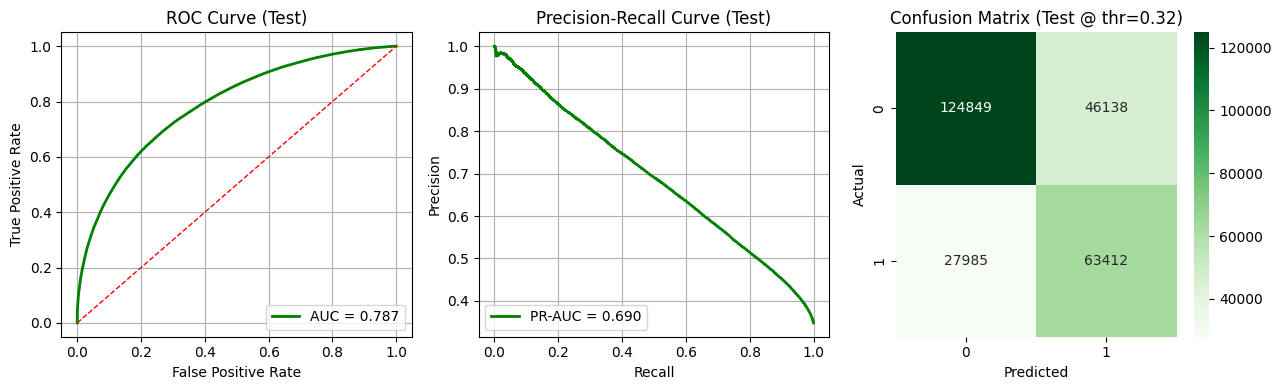

In [ ]:
def plot_train_test_classification_evaluation(
    y_train_true=None, y_train_proba=None,
    y_test_true=None, y_test_proba=None,
    threshold=0.5, dataset_names=("Train", "Test")
):
    datasets = []
    if y_train_true is not None and y_train_proba is not None:
        datasets.append((y_train_true, y_train_proba, dataset_names[0]))
    if y_test_true is not None and y_test_proba is not None:
        datasets.append((y_test_true, y_test_proba, dataset_names[1]))

    for y_true, y_proba, name in datasets:
        y_pred = (y_proba >= threshold).astype(int)

        fig, axes = plt.subplots(1, 3, figsize=(13, 4))

        # ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        roc_auc_val = auc(fpr, tpr)
        axes[0].plot(fpr, tpr, lw=2, color='g', label=f'AUC = {roc_auc_val:.3f}')
        axes[0].plot([0, 1], [0, 1], 'r--', lw=1)
        axes[0].set_xlabel('False Positive Rate')
        axes[0].set_ylabel('True Positive Rate')
        axes[0].set_title(f'ROC Curve ({name})')
        axes[0].legend(loc='lower right')
        axes[0].grid(True)

        # Precision-Recall curve
        precision, recall, _ = precision_recall_curve(y_true, y_proba)
        pr_auc_val = auc(recall, precision)
        axes[1].plot(recall, precision, lw=2, color='g', label=f'PR-AUC = {pr_auc_val:.3f}')
        axes[1].set_xlabel('Recall')
        axes[1].set_ylabel('Precision')
        axes[1].set_title(f'Precision-Recall Curve ({name})')
        axes[1].legend(loc='lower left')
        axes[1].grid(True)

        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axes[2])
        axes[2].set_xlabel('Predicted')
        axes[2].set_ylabel('Actual')
        axes[2].set_title(f'Confusion Matrix ({name} @ thr={threshold:.2f})')

        plt.tight_layout()
        plt.show()


y_val_proba = final_model.predict(X_val)

plot_train_test_classification_evaluation(
    y_train_true=None,
    y_train_proba=None,
    y_test_true=y_val,
    y_test_proba=y_val_proba,
    threshold=best_f1_threshold_lgb
)

**Curva ROC:**

Con un AUC de 0.787 en el conjunto **test**, podemos concluir que el modelo tiene una habilidad discriminativa decente, ya que clasifica correctamente los trenes retrasados por encima de los trenes a tiempo aproximadamente el 79% de las veces. El área bajo la curva confirma que el modelo funciona sustancialmente mejor que una predicción aleatoria, aunque todavía deja espacio para mejoras.

**Precisión-Recall:**

Con un PR-AUC de 0.690 en el conjunto **test**, el modelo demuestra una capacidad moderada para capturar la clase positiva (trenes retrasados) en este escenario desbalanceado. Este valor está muy por encima de la línea base correspondiente a la proporción de la clase positiva (establecida aquí en el percentil 75 de los retrasos), lo que indica que el modelo ofrece un compromiso significativo entre precisión y recall. No obstante, el valor moderado también sugiere que muchos retrasos todavía se pierden o se clasifican incorrectamente como positivos.

**Matriz de confusión:**

La matriz de confusión muestra que el modelo clasifica correctamente la mayoría de los trenes a tiempo y un número considerable de trenes retrasados. Sin embargo, tiende a generar un número bastante elevado de falsos positivos (prediciendo un retraso cuando no ocurre). Esto ayuda al modelo a capturar una buena porción de los retrasos reales, pero también reduce la precisión, ya que muchos de los retrasos predichos resultan ser falsas alarmas. Al mismo tiempo, el modelo todavía pasa por alto un número notable de retrasos reales, mostrando que hay margen para mejorar el recall también.

***

**Las 10 estaciones con más falsos negativos y Errores por provincia:**

In [ ]:
# Creating a DataFrame with true labels, predictions, and probabilities
test_results = pd.DataFrame({
    "y_true": y_val,
    "y_pred": lgb_preds_test,
    "y_proba": lgb_proba_test
})

# Adding original features to the test results
test_results = pd.concat([test_results.reset_index(drop=True), X_val.reset_index(drop=True)], axis=1)

# Create "error_type" column (TP, TN, FP, FN)
def classify_error(row):
    if row["y_true"] == 1 and row["y_pred"] == 1:
        return "TP"
    elif row["y_true"] == 0 and row["y_pred"] == 0:
        return "TN"
    elif row["y_true"] == 0 and row["y_pred"] == 1:
        return "FP"
    else:
        return "FN"

test_results["error_type"] = test_results.apply(classify_error, axis=1)


# Top 10 stations with most false negatives
if "station" in test_results.columns:
    station_errors = (
        test_results.groupby("station", observed=True)["error_type"]
        .value_counts(normalize=True)
        .unstack(fill_value=0)
        .sort_values("FN", ascending=False)
        .head(10)
    )
    print("Top 10 stations with most false negatives (Test set):")
    display(station_errors)

# Errors by province
if "province" in test_results.columns:
    province_errors = (
        test_results.groupby("province", observed=True)["error_type"]
        .value_counts(normalize=True)
        .unstack(fill_value=0)
        .sort_values("FP", ascending=False)
    )
    print("\nErrors by province (Test set):")
    display(province_errors)

Top 10 stations with most false negatives (Test set):


error_type,FN,FP,TN,TP
station,,,,
BOLOGNA_S.RUFFILLO,1.000000,0.000000,0.000000,0.000000
MONZUNO_VADO,1.000000,0.000000,0.000000,0.000000
CORNIGLIA,1.000000,0.000000,0.000000,0.000000
S.BENEDETTO_SAMBRO_CASTIGLIONE_PEPOLI,1.000000,0.000000,0.000000,0.000000
ROSARNO,0.322034,0.000000,0.186441,0.491525
LA_SPEZIA_CENTRALE,0.269231,0.230769,0.269231,0.230769
RIMINI,0.269058,0.147982,0.300448,0.282511
LECCE,0.234043,0.063830,0.680851,0.021277
ALBAREDO,0.215035,0.055070,0.670455,0.059441



Errors by province (Test set):


error_type,FN,FP,TN,TP
province,,,,
VR,0.090766,0.224991,0.329461,0.354782
OUTSIDE_VENETO,0.099270,0.215351,0.395095,0.290284
TV,0.103590,0.165333,0.566383,0.164694
RO,0.132776,0.144152,0.491113,0.231959
VE,0.127545,0.143528,0.540866,0.188060
VI,0.081824,0.135834,0.523502,0.258840
PD,0.119023,0.134116,0.545367,0.201495
BL,0.076102,0.075174,0.806497,0.042227


**Estaciones con más falsos negativos:**

La primera tabla muestra las estaciones donde el modelo tiene más dificultades para predecir retrasos reales. Algunas estaciones presentan una proporción extremadamente alta de falsos negativos, por ejemplo, BOLOGNA_S.RUFFILLO, MONZUNO_VADO, CORNIGLIA y S.BENEDETTO_SAMBRO_CASTIGLIONE_PEPOLI, todas al 100%, lo que indica que el modelo no detectó ningún retraso real en estas estaciones. Otras estaciones, como ROSARNO (32,2%), LA_SPEZIA_CENTRALE (26,9%) y RIMINI (26,9%), también muestran tasas significativas de falsos negativos.

Estos resultados pueden explicarse por el hecho de que hay relativamente pocos datos para estas estaciones. Todas las estaciones mencionadas están fuera de Veneto y no son estaciones principales en términos de tráfico. Como resultado, incluyen un número menor de trenes en el dataset, lo que dificulta que el modelo aprenda patrones de retrasos en estas ubicaciones.

**Errores por provincia:**

La segunda tabla muestra la distribución de los resultados de predicción agregados por provincia. Algunas observaciones:

- VR (Verona) y OUTSIDE_VENETO tienen tasas de falsos positivos relativamente altas (21-22%), lo que sugiere que el modelo a veces predice retrasos que no ocurren. OUTSIDE_VENETO también presenta una alta proporción de verdaderos positivos (29%), lo cual tiene sentido, ya que las estaciones fuera de Veneto incluyen un número relativamente alto de trenes no regionales, que presentan mayores retrasos promedio en el dataset (véase Notebook 1b, sección 6). De manera similar, Verona tiene la mayor proporción de verdaderos positivos (35%), lo que significa que el modelo captura una parte considerable de los retrasos reales allí también.
- BL (Belluno) presenta las tasas de error más bajas en general, con una proporción muy alta de verdaderos negativos (81%) y muy pocos verdaderos positivos (4%), indicando que la mayoría de los trenes se predicen correctamente como a tiempo y los retrasos son poco frecuentes.
- PD, VE, TV (Padova, Venezia, Treviso) muestran tasas de error moderadas, con altas proporciones de verdaderos negativos (54-57%) y proporciones menores de verdaderos positivos (16-20%), reflejando que los retrasos son menos frecuentes y que el modelo predice correctamente la mayoría de los trenes a tiempo.
- RO y VI muestran patrones intermedios, con tasas moderadas de falsos positivos y falsos negativos y un equilibrio entre trenes a tiempo y retrasados correctamente predichos.

***

**Distribución de errores por hora de llegada programada:**

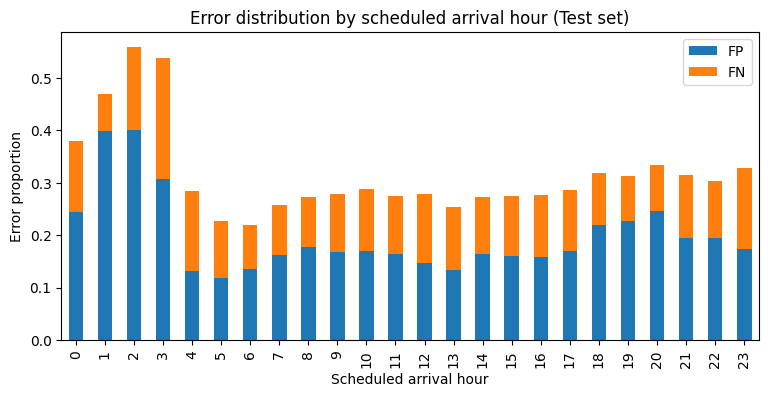

In [ ]:
# Grouping errors by scheduled arrival hour
if "scheduled_arrival_hour" in test_results.columns:
    hour_errors_test = (
        test_results.groupby("scheduled_arrival_hour")["error_type"]
        .value_counts(normalize=True)
        .unstack(fill_value=0)
    )

    # PLotting FP and FN
    hour_errors_test[["FP", "FN"]].plot(kind="bar", stacked=True, figsize=(9,4))
    plt.title("Error distribution by scheduled arrival hour (Test set)")
    plt.xlabel("Scheduled arrival hour")
    plt.ylabel("Error proportion")
    plt.legend()
    plt.show()
else:
    print("Column 'scheduled_arrival_hour' not found in test_results.")

El gráfico de barras muestra la proporción de Falsos Positivos (FP) y Falsos Negativos (FN) para cada hora de llegada programada. Algunas observaciones:

- Horas nocturnas (00:00-03:00): Tanto FP como FN presentan proporciones relativamente altas.
- Horas diurnas: FP y FN son generalmente más bajos, mostrando que el modelo funciona mejor durante las horas operativas habituales, cuando hay más datos disponibles.  
- Horas de la tarde/noche (18:00-21:00): La proporción de FP aumenta ligeramente, lo que sugiere que el modelo puede sobrepredecir retrasos durante las llegadas a última hora de la tarde/noche. FN se mantiene relativamente bajo, por lo que la mayoría de los retrasos reales se capturan correctamente.

En general, el modelo tiende a sobrepredecir retrasos en las horas nocturnas y funciona de manera más confiable durante las principales horas operativas. El menor rendimiento durante las horas de la noche puede reflejar la dificultad del modelo con períodos de tráfico muy bajo, donde los ejemplos de entrenamiento son escasos. Además, como se observó en el Notebook 1b (sección 6), los retrasos tienden a aumentar significativamente durante estas horas, por lo que un peor desempeño del modelo es algo esperado.

* * *

**Error de predicción medio por provincia y categoría:**

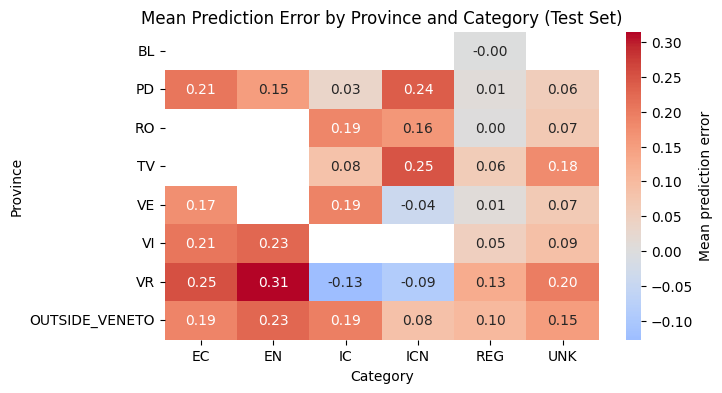

In [ ]:
# Calculating errors as the difference between predicted label and true value
errors_test = test_results["y_pred"] - test_results["y_true"]

# Heatmap for province and category
if all(col in test_results.columns for col in ['province', 'category']):
    heat_data_test = pd.DataFrame({
        'province': test_results['province'],
        'category': test_results['category'],
        'error': errors_test
    })

    # Pivot table to compute mean error per province-category combination
    heat_table_test = heat_data_test.pivot_table(
        values='error',
        index='province',
        columns='category',
        aggfunc='mean',
        observed=False
    )

    # Plotting heatmap
    plt.figure(figsize=(7, 4))
    sns.heatmap(heat_table_test, annot=True, fmt=".2f", cmap='coolwarm', center=0, cbar_kws={'label': 'Mean prediction error'})
    plt.title("Mean Prediction Error by Province and Category (Test Set)")
    plt.xlabel("Category")
    plt.ylabel("Province")
    plt.show()

La tabla muestra el error promedio de predicción para cada combinación de provincia y categoría de tren. Algunas observaciones:

- Algunas provincias presentan una sobrepredicción notable para categorías específicas. Por ejemplo, VR (Verona) tiene un error positivo moderadamente alto para EC (0,25) y EN (0,31), lo que significa que el modelo tiende a sobrestimar el retraso para estas categorías de tren. De manera similar, TV (Treviso) y PD (Padova) muestran una tendencia a la sobrepredicción para ICN (0,25 y 0,24, respectivamente).  
- Algunas celdas son ligeramente negativas (por ejemplo, las categorías IC e ICN para VR (-0,13 y -0,09, respectivamente) y la categoría ICN para VE (Venecia, -0,04)), lo que indica que el modelo subestima los retrasos en estas combinaciones provincia/categoría.  
- Las provincias fuera de Veneto presentan errores positivos moderados en todas las categorías, lo que significa que hay una ligera sobreestimación de los retrasos en paradas fuera de Veneto.

El modelo predice los retrasos de los trenes REG (regionales) con un error mucho menor en comparación con otras categorías en todas las provincias. Los trenes regionales son, con diferencia, la categoría más numerosa en el dataset, lo que proporciona al modelo suficientes datos para aprender patrones más confiables.

En general, el modelo funciona mejor para categorías y provincias con suficientes datos y tiene dificultades cuando el número de observaciones es bajo.

### **6.3 Comparación con baselines de retraso medio**

Ahora evaluaré si el modelo final de LightGBM funciona mejor que dos *baselines* simples que se basan únicamente en estadísticas históricas de retrasos por número de tren y parada de tren. Esto nos permite comprobar si la mayor complejidad de LightGBM proporciona una ventaja real sobre heurísticas simples.

Construiré dos *baselines*: uno basado en el retraso medio en minutos y otro basado en la frecuencia de paradas retrasadas. Después, compararé sus métricas y matrices de confusión lado a lado con las del modelo LightGBM para evaluar si el modelo aporta alguna ventaja sobre estos enfoques.

1. **Baseline de retraso medio:**  
   
   Para este *baseline*, hago lo siguiente:
   - Calculo el retraso medio (en minutos) para cada combinación `train_number`/`station` en el conjunto de entrenamiento usado para entrenar el modelo final de LightGBM (es decir, el conjunto que contiene las paradas del 1 de enero al 30 de abril).  
   - Asigno este retraso medio a cada combinación correspondiente de tren/parada en el conjunto de test (paradas del 1 al 31 de mayo).  
   - Aplico un umbral fijo de 4 minutos para convertir el retraso medio en una predicción binaria (1 = retraso ≥ 4 min, 0 = retraso < 4 min).  
   - Calculo las métricas de clasificación.

2. **Baseline de frecuencia:**

   Para este *baseline*, en lugar de usar los retrasos en minutos, calculo la fracción histórica de paradas retrasadas para cada combinación `train_number`/`station` en el conjunto de entrenamiento:

   $$
   f_{\text{delay}}(\text{train, station}) = \frac{\#\{\text{paradas con retraso} \ge 4 \text{ min}\}}{\#\{\text{total de paradas}\}}
   $$

   Por ejemplo, si el tren 9956 se detuvo 10 veces en la estación A en el conjunto de entrenamiento, y 3 de esas paradas tuvieron un retraso ≥ 4 minutos, entonces la fracción histórica de paradas retrasadas sería 3/10 = 0,3.

   Esta fracción produce así un puntaje entre 0 y 1. Para decidir si una parada se predice como retrasada (es decir, con retraso ≥ 4 minutos), se barre un rango de umbrales $t \in [0,1]$ en el siguiente sistema:

   $$
   \text{predicha como retrasada} =
   \begin{cases}
   1 & \text{si } f_{\text{delay}}(\text{train, station}) \ge t \\
   0 & \text{de otro modo}
   \end{cases}
   $$

   y se selecciona el umbral $t$ que maximiza el F1 en el conjunto de test. Luego, se calculan las mismas métricas de clasificación estándar.  

   Cabe destacar que este *baseline* tiene acceso a la fracción histórica exacta de paradas retrasadas por tren/parada, información que LightGBM nunca vio. Lo incluyo para comparación, pero no se proporcionó esta información a LightGBM porque incluirla habría convertido al modelo en un simple memorizador de resultados pasados en lugar de un predictor basado en las características mismas. El modelo LightGBM está diseñado para generalizar a partir de las características del tren, del viaje y de la estación, y en escenarios de despliegue real, las fracciones históricas pueden no estar siempre disponibles para cada combinación tren/estación.

,Accuracy,Precision,Recall,F1,ROC_AUC,PR_AUC
Mean-delay baseline (≥ 4 min),0.651667,0.000000,0.000000,0.000000,0.786797,0.685474
Frequency baseline (sweep),0.703061,0.555764,0.735232,0.633024,0.786797,0.685474
LightGBM,0.717502,0.578841,0.693808,0.631132,0.787297,0.689995


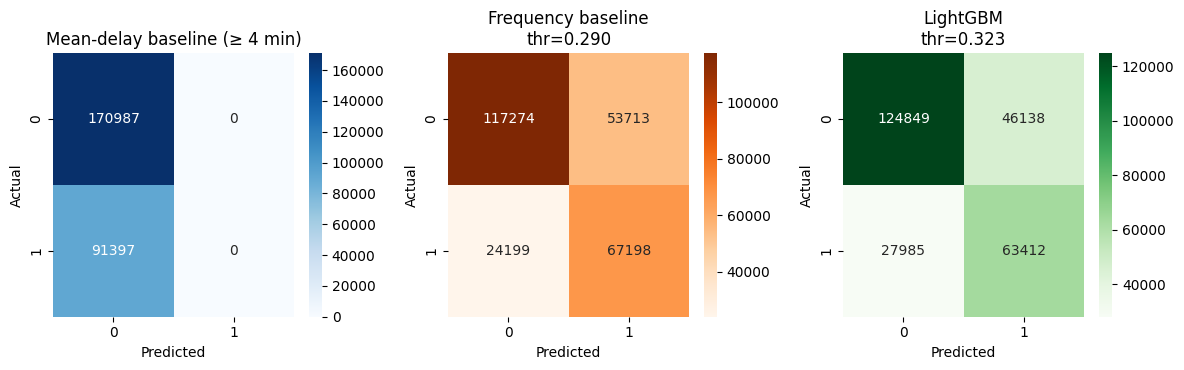

In [ ]:
# Copying datasets
X_train_copy = X_train.copy()
X_train_copy['target'] = y_train.values
X_val_copy = X_val.copy()
X_val_copy['target'] = y_val.values

# Mean-delay baseline
mean_delay_train_station = (
    X_train_copy.groupby(['train_number', 'station'], observed=False)['target']
    .mean()
    .reset_index()
    .rename(columns={'target': 'mean_delay'})
)

X_val_copy = X_val_copy.merge(mean_delay_train_station, on=['train_number', 'station'], how='left')
X_val_copy['mean_delay'] = X_val_copy['mean_delay'].fillna(0)

# Predictions with fixed threshold at 4 minutes
X_val_copy['pred_mean_baseline_fixed'] = (X_val_copy['mean_delay'] >= 4).astype(int)

metrics_mean_fixed = {
    'Accuracy': accuracy_score(X_val_copy['target'], X_val_copy['pred_mean_baseline_fixed']),
    'Precision': precision_score(X_val_copy['target'], X_val_copy['pred_mean_baseline_fixed'], zero_division=0),
    'Recall': recall_score(X_val_copy['target'], X_val_copy['pred_mean_baseline_fixed']),
    'F1': f1_score(X_val_copy['target'], X_val_copy['pred_mean_baseline_fixed']),
    'ROC_AUC': roc_auc_score(X_val_copy['target'], X_val_copy['mean_delay']),
    'PR_AUC': average_precision_score(X_val_copy['target'], X_val_copy['mean_delay'])
}


# Frequency baseline
freq_train_station = (
    X_train_copy.groupby(['train_number','station'], observed=False)['target']
    .mean()
    .reset_index()
    .rename(columns={'target':'freq_delay'})
)

X_val_copy = X_val_copy.merge(freq_train_station, on=['train_number','station'], how='left')
X_val_copy['freq_delay'] = X_val_copy['freq_delay'].fillna(0)

thresholds = np.linspace(0, 1, 101)
best_f1 = 0
best_threshold = 0
for t in thresholds:
    preds = (X_val_copy['freq_delay'] >= t).astype(int)
    f1 = f1_score(X_val_copy['target'], preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

X_val_copy['pred_freq_baseline_sweep'] = (X_val_copy['freq_delay'] >= best_threshold).astype(int)

metrics_freq_sweep = {
    'Accuracy': accuracy_score(X_val_copy['target'], X_val_copy['pred_freq_baseline_sweep']),
    'Precision': precision_score(X_val_copy['target'], X_val_copy['pred_freq_baseline_sweep']),
    'Recall': recall_score(X_val_copy['target'], X_val_copy['pred_freq_baseline_sweep']),
    'F1': f1_score(X_val_copy['target'], X_val_copy['pred_freq_baseline_sweep']),
    'ROC_AUC': roc_auc_score(X_val_copy['target'], X_val_copy['freq_delay']),
    'PR_AUC': average_precision_score(X_val_copy['target'], X_val_copy['freq_delay'])
}


# LightGBM model metrics for comparison
metrics_lgb = {
    'Accuracy': accuracy_score(y_val, lgb_preds_test),
    'Precision': precision_score(y_val, lgb_preds_test),
    'Recall': recall_score(y_val, lgb_preds_test),
    'F1': f1_score(y_val, lgb_preds_test),
    'ROC_AUC': roc_auc_score(y_val, lgb_proba_test),
    'PR_AUC': average_precision_score(y_val, lgb_proba_test)
}

# Metrics DataFrame
metrics_df = pd.DataFrame(
    [metrics_mean_fixed, metrics_freq_sweep, metrics_lgb],
    index=['Mean-delay baseline (≥ 4 min)', 'Frequency baseline (sweep)', 'LightGBM']
)
display(metrics_df)

# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(12, 3.8))

# Mean-delay baseline
cm_fixed = confusion_matrix(X_val_copy['target'], X_val_copy['pred_mean_baseline_fixed'])
sns.heatmap(cm_fixed, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Mean-delay baseline (≥ 4 min)')

# Frequency baseline
cm_sweep = confusion_matrix(X_val_copy['target'], X_val_copy['pred_freq_baseline_sweep'])
sns.heatmap(cm_sweep, annot=True, fmt='d', cmap='Oranges', ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title(f'Frequency baseline\nthr={best_threshold:.3f}')

# LightGBM
cm_lgb = confusion_matrix(y_val, lgb_preds_test)
sns.heatmap(cm_lgb, annot=True, fmt='d', cmap='Greens', ax=axes[2])
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_title(f'LightGBM\nthr={best_f1_threshold_lgb:.3f}')

plt.tight_layout()
plt.show()

La comparación de métricas muestra lo siguiente:

- La mean-delay baseline falla por completo en las métricas binarias, demostrando que el retraso promedio en minutos por combinación de tren/estación no proporciona suficiente información para predecir si una parada se retrasará ≥ 4 minutos.  
- La frequency baseline logra un rendimiento sólido al utilizar directamente la fracción histórica de paradas retrasadas por tren/estación, codificando efectivamente casi toda la señal predictiva.  
- El modelo LightGBM final logra métricas casi idénticas a las de la frequency baseline, a pesar de no tener acceso directo a dicha fracción histórica. Esto indica que LightGBM está reconstruyendo la señal predictiva a partir de las características disponibles. Esta generalización es crucial porque, en escenarios de implementación realistas, el modelo puede encontrar trenes o estaciones nuevos para los cuales no se puede calcular ninguna fracción histórica; en tales casos, depender de memorizar los datos históricos fallaría, mientras que LightGBM aún puede realizar predicciones válidas.

## **7. Interpretabilidad del modelo**

### **7.1 Explicación del modelo con LIME**

Para comprender mejor el comportamiento de el modelo, utilizaré LIME (Local Interpretable Model-agnostic Explanations) para evaluar qué características influyen más fuertemente en las predicciones.

,importance
mean_delay_station_train_day,0.153428
mean_delay_station_train,0.064139
station,0.043215
train_number,0.030405
mean_delay_station_day_hour_half,0.018998
is_holiday,0.017086
destination,0.009685
origin,0.006272
day_of_week,0.004711
category,0.004315


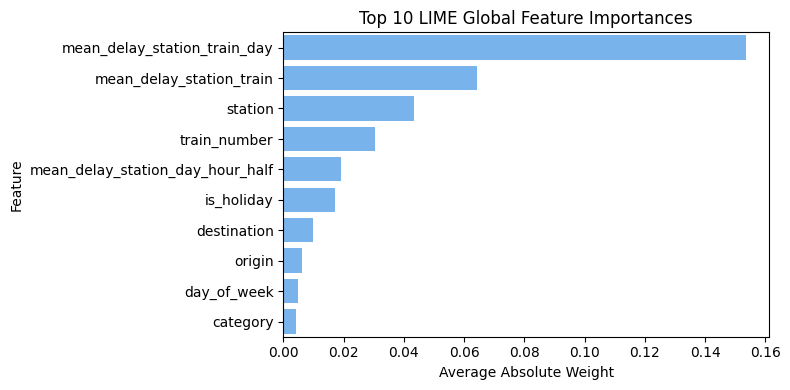

In [ ]:
categorical_features = [
    "category",
    "origin",
    "destination",
    "station",
    "previous_station",
    "province",
    "day_of_week",
    "train_number"
]

# Preparing test features for LIME
X_test_lime = X_val.copy()

# Encoding categorical columns in both train and test
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train_lime = X_train.copy()
X_train_lime[categorical_features] = encoder.fit_transform(X_train_lime[categorical_features])
X_test_lime[categorical_features] = encoder.transform(X_test_lime[categorical_features])

# LIME explainer using the encoded training data
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_lime),
    feature_names=X_train_lime.columns.tolist(),
    class_names=['No Delay', 'Delay'],
    categorical_features=[X_train_lime.columns.get_loc(c) for c in categorical_features],
    discretize_continuous=True,
    mode='classification',
    random_state=42
)

# Predict function returning probabilities
def lgb_predict_proba(X):
    probs = final_model.predict(X)
    return np.vstack([1 - probs, probs]).T

# Explaining multiple instances to get global feature importance
num_instances = 100
sample_indices = np.random.choice(X_test_lime.shape[0], num_instances, replace=False)

feature_importances = pd.DataFrame(0.0, index=X_test_lime.columns, columns=['importance'])

for idx in sample_indices:
    row = X_test_lime.iloc[idx].values
    exp = explainer.explain_instance(data_row=row, predict_fn=lgb_predict_proba, num_features=len(X_test_lime.columns))
    for feature, weight in exp.as_list():
        # Finding the actual feature name from column list
        matched_features = [col for col in feature_importances.index if col in feature]
        if matched_features:
            feature_name = matched_features[0]
            feature_importances.loc[feature_name, 'importance'] += abs(weight)
        else:
            continue

# Averaging over sampled instances
feature_importances['importance'] /= num_instances
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Displaying top 10 features
display(feature_importances.head(10))

plt.figure(figsize=(8,4))
top_features = feature_importances.head(10)
sns.barplot(x=top_features['importance'], y=top_features.index, color='#66b3ff')
plt.title('Top 10 LIME Global Feature Importances')
plt.xlabel('Average Absolute Weight')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

El modelo se basa en gran medida en los patrones históricos de retrasos, particularmente en `mean_delay_station_train_day` y `mean_delay_station_train`. Esto era bastante esperable, ya que estas características históricas fueron diseñadas para proporcionar al modelo información sobre el desempeño pasado con el fin de predecir retrasos futuros.

`station` y `train_number`, que también contribuyen a las dos variables anteriores, también influyen en las predicciones: estas características probablemente permiten al modelo distinguir efectos de congestión o de programación específicos de cada ruta.

Características como `day_of_week` o `category` muestran una importancia global relativamente baja. En el caso de `day_of_week`, puede deberse a que el modelo captura la mayoría de los patrones relevantes a través de las características de retrasos históricos, que ya reflejan los efectos de días laborables/fines de semana. Finalmente, el hecho de que la característica `category` tenga una influencia limitada puede deberse tanto a la fuerte predominancia de trenes REG en el conjunto de datos como al ruido introducido por la categoría UNK (desconocida), que diluye la señal de las demás categorías.

### **7.2 Análisis de sesgos**

Para comprobar posibles sesgos sistemáticos en las predicciones del modelo, ahora calculo los residuos (diferencias entre los valores reales y los predichos) en el conjunto de test.

A continuación, agrupo estos residuos por características categóricas para ver si ciertos grupos son consistentemente sobreestimados o subestimados.

**Calculando predicciones y residuos para el análisis de errores:**

In [ ]:
# Residuals (actual labels - predicted probabilities)
residuals = y_val - lgb_proba_test

# Creating a df for error analysis
df_errors = X_val.copy()
df_errors['residual'] = residuals

**Sesgos por provincia:**

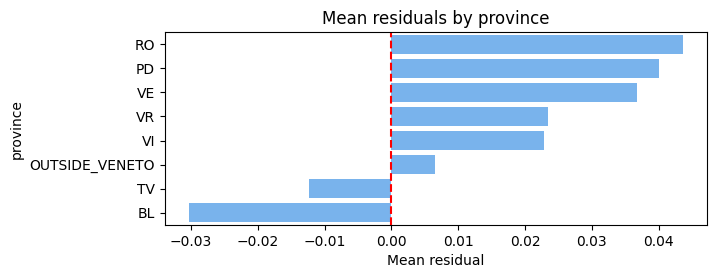

In [ ]:
feature = 'province'

# Aggregate residuals
bias_analysis = (
    df_errors.groupby(feature, observed=True)['residual']
    .agg(['mean', 'std', 'count'])
    .reset_index()
    .sort_values('mean', ascending=False)
)

order = bias_analysis.sort_values('mean', ascending=False)[feature]

# Plotting
plt.figure(figsize=(7, 2.5))
sns.barplot(data=bias_analysis, x='mean', y=feature, color='#66b3ff', order=order)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Mean residual')
plt.ylabel(feature)
plt.title(f'Mean residuals by {feature}')
plt.show()

El gráfico de barras muestra la media de los residuos (errores de predicción) agrupados por provincia.

La mayoría de las provincias venetas (RO, PD, VE, VR, VI) presentan residuos medios positivos pequeños (0,02-0,04). Esto significa que el modelo, en promedio, subestima ligeramente los retrasos en estas áreas. TV y BL, en cambio, muestran residuos medios negativos pequeños (-0,01 y -0,03, respectivamente), lo que sugiere una ligera sobreestimación en esas provincias. Para las provincias fuera de Veneto, el residuo medio está bastante cerca de cero, lo que indica que las predicciones están bastante equilibradas en promedio.

En general, el modelo no presenta errores sistemáticos importantes entre provincias.

***

**Sesgos por categoría:**

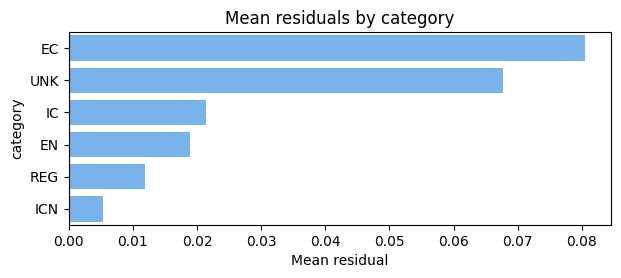

In [ ]:
feature = 'category'

# Aggregate residuals
bias_analysis = (
    df_errors.groupby(feature, observed=True)['residual']
    .agg(['mean', 'std', 'count'])
    .reset_index()
    .sort_values('mean', ascending=False)
)

order = bias_analysis.sort_values('mean', ascending=False)[feature]

# Plotting
plt.figure(figsize=(7, 2.5))
sns.barplot(data=bias_analysis, x='mean', y=feature, color='#66b3ff', order=order)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Mean residual')
plt.ylabel(feature)
plt.title(f'Mean residuals by {feature}')
plt.show()

Este gráfico muestra los residuos medios agrupados por categoría de tren.

En general, el modelo tiende a subestimar los retrasos en todas las categorías de tren. La subestimación es muy pequeña para los trenes ICN y REG, pequeña para los trenes IC y EN, y moderada para los trenes EC y los de categoría desconocida. Los datos sugieren que el modelo está generalmente bien calibrado, pero tiende a subestimar los retrasos, especialmente en categorías de tren menos comunes o especiales.

***

**Sesgos por hora de llegada programada:**

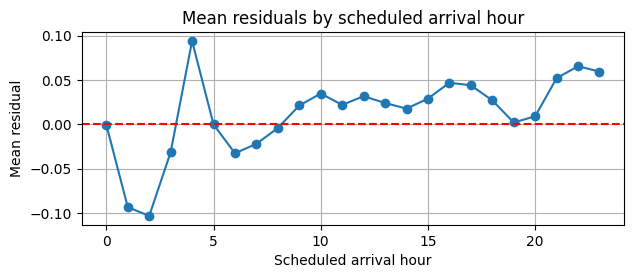

In [ ]:
feature = 'scheduled_arrival_hour'

# Aggregate residuals
bias_analysis = (
    df_errors.groupby(feature)['residual']
    .agg(['mean', 'std', 'count'])
    .reset_index()
    .sort_values(feature)
)

# Plotting
plt.figure(figsize=(7, 2.5))
plt.plot(bias_analysis[feature], bias_analysis['mean'], marker='o')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Scheduled arrival hour')
plt.ylabel('Mean residual')
plt.title('Mean residuals by scheduled arrival hour')
plt.grid(True)
plt.show()

Este gráfico muestra los residuos medios agrupados por hora de llegada programada.

En general, el modelo presenta desviaciones solo ligeras, pero se observan algunos patrones temporales:

- Durante las horas nocturnas, los residuos medios oscilan aproximadamente entre -0,10 y +0,10. Esto coincide con nuestra observación previa de que estas horas muestran patrones de retraso anómalos, donde los retrasos promedio aumentan inesperadamente. Los residuos oscilantes sugieren que el modelo puede primero subestimar los retrasos, luego sobrecompensar ligeramente y posteriormente ajustar las predicciones. Debido a que estas horas tienen pocas observaciones, el modelo es más sensible a variaciones individuales, lo que puede explicar las fluctuaciones de los residuos.
- La mayoría de las horas diurnas tienen residuos cercanos a cero o ligeramente positivos, lo que sugiere que las predicciones son bastante precisas, con una subestimación menor.
- Las horas de la tarde muestran residuos consistentemente positivos, lo que significa que el modelo subestima ligeramente los retrasos durante la tarde.

En resumen, el modelo captura razonablemente bien los efectos de la hora del día, con una ligera subestimación de los retrasos durante el día.

***

**Sesgos por día de la semana:**

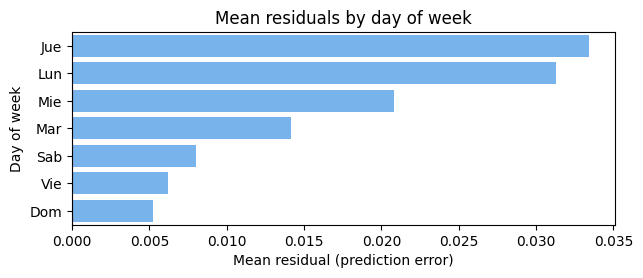

In [ ]:
feature = 'day_of_week'

# Aggregate residuals
bias_analysis = (
    df_errors.groupby(feature, observed=True)['residual']
    .agg(['mean', 'std', 'count'])
    .reset_index()
)

day_labels = {0: 'Lun', 1: 'Mar', 2: 'Mie', 3: 'Jue', 4: 'Vie', 5: 'Sab', 6: 'Dom'}
bias_analysis['day_label'] = bias_analysis[feature].map(day_labels)
bias_analysis = bias_analysis.sort_values('mean', ascending=False)

# Plotting
plt.figure(figsize=(7, 2.5))
sns.barplot(data=bias_analysis, x='mean', y='day_label', color='#66b3ff', order=bias_analysis['day_label'])
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Mean residual (prediction error)')
plt.ylabel('Day of week')
plt.title('Mean residuals by day of week')
plt.show()

Los residuos medios a lo largo de los días de la semana muestran que todos los días presentan pequeños residuos positivos, lo que confirma que el modelo subestima ligeramente los retrasos en promedio. La subestimación es más pronunciada durante los días laborables, en particular los lunes y los jueves, mientras que los fines de semana presentan residuos positivos más pequeños.  

Este patrón puede reflejar el tráfico ferroviario subyacente: los fines de semana circulan menos trenes y hay menor variabilidad en los retrasos, por lo que las predicciones del modelo se acercan más a los retrasos reales, mientras que entre semana se observa un mayor tráfico y una mayor variabilidad en los retrasos, lo que conduce a subestimaciones ligeramente mayores.

## **8. Conclusiones**

El modelo predictivo desarrollado en este trabajo fue capaz de capturar señales significativas para la predicción de retrasos ferroviarios. Con un ROC-AUC de 0.787 y un PR-AUC de 0.690 en el conjunto de test, el modelo aprendió patrones relevantes en los datos y puede distinguir entre trenes puntuales y retrasados mejor que el azar. El rendimiento global es moderado, con un F1-score de 0.631 y una precisión de 0.579.

Varios factores pueden limitar el rendimiento:

- El conjunto de datos completo cubre solo de enero a mayo de 2025, sin meses repetidos ni ciclos estacionales, lo que puede limitar la capacidad del modelo para capturar patrones a largo plazo en el comportamiento de los trenes.
- El conjunto de características es relativamente restringido: solo se utilizaron metadatos relacionados con el horario y categorías, complementados con variables basadas en unos pocos meses de registros históricos. No se incluyeron variables externas que influyen fuertemente en los retrasos (p. ej., condiciones meteorológicas, incidencias en la infraestructura o en los trenes, obras en la línea).
- Finalmente, la predicción de retrasos es intrínsecamente difícil porque muchos retrasos son estocásticos, lo que introduce ruido en los residuos que ningún modelo puede predecir completamente.

El trabajo futuro podría explorar modelos de secuencia neuronal más avanzados (como LSTMs o Transformers) para capturar mejor la propagación temporal de los retrasos, empleando potencialmente codificaciones seno/coseno para variables cíclicas como la hora del día o el día de la semana. Otras mejoras posibles incluyen:

- Construir un grafo de estaciones (nodos) y líneas de tren (aristas) y aplicar Graph Neural Networks para aprender representaciones de estaciones y de la topología de las líneas.
- Crear clusters de estaciones (por proximidad o número de conexiones, p. ej., usando k-means sobre coordenadas GPS) y calcular estadísticas agregadas sobre clusters o líneas de tren para usarlas como nuevas características.
- Integrar fuentes de datos externas más ricas y complejas (p. ej., información meteorológica e incidencias en las líneas ferroviarias).